In [2]:
import datetime as dt
import sys
import numpy as np
from numpy import cumsum, log, polyfit, sqrt, std, subtract
from numpy.random import randn
import pandas as pd
# from pandas_datareader import data as web
import seaborn as sns
from pylab import rcParams 
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from arch import arch_model
from numpy.linalg import LinAlgError
from scipy import stats
import statsmodels.api as sm
import statsmodels.tsa.api as tsa
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, q_stat, adfuller
from sklearn.metrics import mean_squared_error, mean_absolute_error
from scipy.stats import probplot, moment
from arch import arch_model
from arch.univariate import ConstantMean, GARCH, Normal
from sklearn.model_selection import TimeSeriesSplit

from statsmodels.tsa.arima.model import ARIMA
from itertools import product
from numpy.lib.stride_tricks import sliding_window_view
from sklearn.model_selection import train_test_split

import tqdm

import itertools
import json
import os
import random

import warnings

In [3]:
from utils import read_txn_data, preprocess_txn_data, compute_lob_features, create_lob_dataset, merge_txn_and_lob

In [4]:
%matplotlib inline
pd.set_option('display.max_columns', None)
warnings.filterwarnings('ignore')
sns.set(style="darkgrid", color_codes=True)
rcParams['figure.figsize'] = 8,4

In [5]:
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F

In [6]:
trx_df = read_txn_data(use_load=False)
trx_df = preprocess_txn_data(trx_df, freq='1min')
trx_df['log_deseasoned_total_volume'] = np.log(trx_df['deseasoned_total_volume'] + 1e-07)

lob_df = create_lob_dataset(use_load=False)

df_merged = merge_txn_and_lob(trx_df, lob_df)
df_merged.head()

trx Data loaded successfully.
preprocessed lob Data loaded successfully.


,datetime,buy_volume,sell_volume,buy_txn,sell_txn,volume_imbalance,txn_imbalance,total_volume,mean_volume,deseasoned_total_volume,log_deseasoned_total_volume,ask_volume,bid_volume,ask_slope_1,ask_slope_5,ask_slope_10,bid_slope_1,bid_slope_5,bid_slope_10,spread,lob_volume_imbalance,slope_imbalance_1,slope_imbalance_5,slope_imbalance_10
5819,2018-06-04 22:00:05+00:00,0.059804,0.730357,5.0,10.0,0.670553,5.0,0.790162,4.380444,0.180384,-1.712667,2695.804973,586356.113693,1761.630667,2695.804973,2695.804973,3.972121,53.502450,160.246934,6.19,583660.308720,1757.658546,2642.302523,2535.558040
5820,2018-06-04 22:01:05+00:00,0.089359,0.849477,3.0,4.0,0.760118,1.0,0.938836,3.692009,0.254289,-1.369285,2699.165417,586350.938081,1765.312385,2699.165417,2699.165417,4.017044,52.408273,155.071322,4.97,583651.772664,1761.295341,2646.757144,2544.094095
5821,2018-06-04 22:02:05+00:00,0.313458,0.508952,2.0,4.0,0.195494,2.0,0.822410,3.324900,0.247349,-1.396955,2657.946212,586317.596946,1723.843180,2657.946212,2657.946212,3.831055,46.578294,158.194750,4.90,583659.650734,1720.012125,2611.367918,2499.751462
5822,2018-06-04 22:03:05+00:00,0.000992,0.199219,1.0,4.0,0.198227,3.0,0.200211,4.128645,0.048493,-3.026331,2650.599402,586308.612876,1718.061157,2650.599402,2650.599402,3.631836,51.036074,160.641345,4.32,583658.013474,1714.429321,2599.563327,2489.958056
5823,2018-06-04 22:04:05+00:00,0.172042,0.000000,7.0,0.0,0.172042,7.0,0.172042,6.271124,0.027434,-3.595966,2650.082079,586314.173248,1715.979046,2650.082079,2650.082079,3.704804,51.092926,160.489197,4.32,583664.091169,1712.274243,2598.989153,2489.592882


## TME implementation

### Data loaders

In [ ]:
random.seed(12345)

h = 5  # window length
batch_size = 128

# -----------------------------
df = df_merged.sort_values('datetime').reset_index(drop=True)
# STEP 1: Create time-of-day feature
df['time_of_day'] = df['datetime'].dt.strftime('%H:%M')

# -----------------------------
# STEP 2: Split indices (AFTER creating lags!)
n_total = len(df)
n_train = int(0.7 * n_total)
n_val = int(0.1 * n_total)

# -----------------------------
# STEP 3: Create deseasonalizing map using per-time volume means from train only
train_deseason_df = df.iloc[:n_train]
mean_volume_by_time = train_deseason_df.groupby('time_of_day')['total_volume'].mean()
df['mean_volume'] = df['time_of_day'].map(mean_volume_by_time)

df['deseasoned_total_volume'] = df['total_volume'] / df['mean_volume']
df['log_deseasoned_total_volume'] = np.log(df['deseasoned_total_volume'] + 1e-7)
df['target'] = df['deseasoned_total_volume']

del train_deseason_df

# -----------------------------
# STEP 4: Define the source-specific features
source1_cols = ['buy_volume', 'sell_volume', 'buy_txn', 'sell_txn', 'volume_imbalance', 'txn_imbalance']
source2_cols = ['ask_volume', 'bid_volume', 'ask_slope_1', 'ask_slope_5', 'ask_slope_10', 'bid_slope_1', 'bid_slope_5', 'bid_slope_10', 'spread',
       'lob_volume_imbalance', 'slope_imbalance_1', 'slope_imbalance_5', 'slope_imbalance_10']
# target_col = 'log_deseasoned_total_volume'
target_col = 'target'
target_direct_col = 'total_volume'
weight_col = 'mean_volume'
datetime_col = 'datetime'

# # Normalize source1 and source2 features using training data only
from sklearn.preprocessing import StandardScaler

scaler1 = StandardScaler()
scaler2 = StandardScaler()

# Fit only on training portion
source1_train_raw = df[source1_cols].iloc[:n_train]
source2_train_raw = df[source2_cols].iloc[:n_train]

scaler1.fit(source1_train_raw)
scaler2.fit(source2_train_raw)

# Apply normalization to the whole dataset
df[source1_cols] = scaler1.transform(df[source1_cols])
df[source2_cols] = scaler2.transform(df[source2_cols])


# --- Create rolling windows efficiently ---
source1_array = df[source1_cols].values  # shape (N, F1)
source2_array = df[source2_cols].values  # shape (N, F2)
target_array = df[target_col].values + 1e-7  # shape (N,)
target_direct_array = df[target_direct_col].values + 1e-7  # shape (N,)
weight_array = df[weight_col].values  # shape (N,)
timestamps_array = df[datetime_col].values


# Create sliding windows ([:-1] in windows and [h:] in targets make sure the targets are matched with corresponding features)
source1_windows = sliding_window_view(source1_array, window_shape=(h,), axis=0)[:-1]  # shape (N - h, F1, h)
source2_windows = sliding_window_view(source2_array, window_shape=(h,), axis=0)[:-1]  # shape (N - h, F2, h)
y = target_array[h:]
w = weight_array[h:]
timestamps = timestamps_array[h:]

# Convert to tensors
source1_tensor = torch.tensor(source1_windows, dtype=torch.float32)
source2_tensor = torch.tensor(source2_windows, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.float32)
w_tensor = torch.tensor(w, dtype=torch.float32)

# --- Time-based split (preserving time order) ---
n_total = len(y_tensor)
n_train = int(n_total * 0.7)
n_val = int(n_total * 0.1)

source1_train, source1_val, source1_test = source1_tensor[:n_train], source1_tensor[n_train:n_train + n_val], source1_tensor[n_train + n_val:]
source2_train, source2_val, source2_test = source2_tensor[:n_train], source2_tensor[n_train:n_train + n_val], source2_tensor[n_train + n_val:]
y_train, y_val, y_test = y_tensor[:n_train], y_tensor[n_train:n_train + n_val], y_tensor[n_train + n_val:]
w_train, w_val, w_test = w_tensor[:n_train], w_tensor[n_train:n_train + n_val], w_tensor[n_train + n_val:]

# (Optional) timestamps split for tracking
timestamps_train = timestamps[:n_train]
timestamps_val = timestamps[n_train:n_train + n_val]
timestamps_test = timestamps[n_train + n_val:]

# Dataset ready for PyTorch training
train_dataset = torch.utils.data.TensorDataset(source1_train, source2_train, y_train, w_train)
val_dataset = torch.utils.data.TensorDataset(source1_val, source2_val, y_val, w_val)
test_dataset = torch.utils.data.TensorDataset(source1_test, source2_test, y_test, w_test)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

## function for dataset creation for hyperparams search
def create_datasets(source1_array, source2_array, target_array, weight_array, batch_size, h):
       # Create sliding windows ([:-1] in windows and [h:] in targets make sure the targets are matched with corresponding features)
       source1_windows = sliding_window_view(source1_array, window_shape=(h,), axis=0)[:-1]  # shape (N - h, F1, h)
       source2_windows = sliding_window_view(source2_array, window_shape=(h,), axis=0)[:-1]  # shape (N - h, F2, h)
       y = target_array[h:]
       w = weight_array[h:]

       # Convert to tensors
       source1_tensor = torch.tensor(source1_windows, dtype=torch.float32)
       source2_tensor = torch.tensor(source2_windows, dtype=torch.float32)
       y_tensor = torch.tensor(y, dtype=torch.float32)
       w_tensor = torch.tensor(w, dtype=torch.float32)

       # --- Time-based split (preserving time order) ---
       n_total = len(y_tensor)
       n_train = int(n_total * 0.7)
       n_val = int(n_total * 0.1)

       source1_train, source1_val, source1_test = source1_tensor[:n_train], source1_tensor[n_train:n_train + n_val], source1_tensor[n_train + n_val:]
       source2_train, source2_val, source2_test = source2_tensor[:n_train], source2_tensor[n_train:n_train + n_val], source2_tensor[n_train + n_val:]
       y_train, y_val, y_test = y_tensor[:n_train], y_tensor[n_train:n_train + n_val], y_tensor[n_train + n_val:]
       w_train, w_val, w_test = w_tensor[:n_train], w_tensor[n_train:n_train + n_val], w_tensor[n_train + n_val:]

       # Dataset ready for PyTorch training
       train_dataset = torch.utils.data.TensorDataset(source1_train, source2_train, y_train, w_train)
       val_dataset = torch.utils.data.TensorDataset(source1_val, source2_val, y_val, w_val)
       test_dataset = torch.utils.data.TensorDataset(source1_test, source2_test, y_test, w_test)

       train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
       val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
       test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

       return train_loader, val_loader, test_loader


### TME components 

In [65]:
class BilinearRegressor(nn.Module):
    def __init__(self, d, h, latent_variable):
        """
        d: number of features in the source data
        h: number of lags in the source data
        latent_variable (bool): if True the class is devoted for modeling latent variable z, if False => y|s_i
        """
        super().__init__()
        self.latent_variable = latent_variable

        # Mean parameters
        self.L_mu = nn.Parameter(torch.empty(d))
        self.R_mu = nn.Parameter(torch.empty(h))
        self.b_mu = nn.Parameter(torch.zeros(1))

        # Xavier init for 1D weight tensors
        # nn.init.xavier_uniform_(self.L_mu.unsqueeze(0))
        # nn.init.xavier_uniform_(self.R_mu.unsqueeze(0))

        nn.init.xavier_normal_(self.L_mu.unsqueeze(0))
        nn.init.xavier_normal_(self.R_mu.unsqueeze(0))

        if not self.latent_variable:
            self.L_sigma = nn.Parameter(torch.empty(d))
            self.R_sigma = nn.Parameter(torch.empty(h))
            self.b_sigma = nn.Parameter(torch.zeros(1))

            # nn.init.xavier_uniform_(self.L_sigma.unsqueeze(0))
            # nn.init.xavier_uniform_(self.R_sigma.unsqueeze(0))

            nn.init.xavier_normal_(self.L_sigma.unsqueeze(0))
            nn.init.xavier_normal_(self.R_sigma.unsqueeze(0))

    def forward(self, x):  # x: (B, d, h)
        mu = torch.einsum('bdh,d,h->b', x, self.L_mu, self.R_mu) + self.b_mu  # [B]
        if self.latent_variable:
            return mu
        log_var = torch.einsum('bdh,d,h->b', x, self.L_sigma, self.R_sigma) + self.b_sigma
        log_var = torch.clamp(log_var, min=-10, max=10)
        var = torch.exp(log_var)  # Ensure positivity
        return mu, var
    

class TME(nn.Module):
    def __init__(self, d1, d2, h):
        super().__init__()
        self.target1 = BilinearRegressor(d1, h, latent_variable=False)
        self.target2 = BilinearRegressor(d2, h, latent_variable=False)
        self.latent1 = BilinearRegressor(d1, h, latent_variable=True)
        self.latent2 = BilinearRegressor(d2, h, latent_variable=True)

    def forward(self, x1, x2, return_all=False):
        # x1: (B, d1, h), x2: (B, d2, h)
        mu1, var1 = self.target1(x1)  # [B], [B]
        mu2, var2 = self.target2(x2)

        logit1 = self.latent1(x1)
        logit2 = self.latent2(x2)

        logits = torch.stack([logit1, logit2], dim=1)  # [B, num_sources]
        probs = F.softmax(logits, dim=1)     # [B, num_sources]

        
        # Clamp to avoid numerical instability
        mu1 = torch.clamp(mu1, -20, 20)
        mu2 = torch.clamp(mu2, -20, 20)
        var1 = torch.clamp(var1, min=1e-5, max=20)
        var2 = torch.clamp(var2, min=1e-5, max=20)

        # Mixture of expected values under log-normal
        exp1 = torch.exp(mu1 + 0.5 * var1)
        exp2 = torch.exp(mu2 + 0.5 * var2)
        final_pred = probs[:, 0] * exp1 + probs[:, 1] * exp2  # [B]

        var1_lognormal = torch.exp(2*mu1 + var1) * (torch.exp(var1) - 1)
        var2_lognormal = torch.exp(2*mu2 + var2) * (torch.exp(var2) - 1)
        aleatoric_var = probs[:, 0] * var1_lognormal + probs[:, 1] * var2_lognormal  # [B]
        epistemic_var = probs[:, 0] * torch.square(exp1) + probs[:, 1] * torch.square(exp2)  # [B]

        if return_all:
            return final_pred, aleatoric_var, epistemic_var, mu1, var1, mu2, var2, probs
        return final_pred


def tme_loss(y, mu1, var1, mu2, var2, probs, model, l2_lambda=0.1):
    """
    Implements:
        -ln ∑_s [ lognormal(y_t | μ_s, σ_s^2) * P(z_t = s | x) ] + λ * ||θ||^2
    """

    eps = 1e-8  # for numerical stability
    log_y = torch.log(y)# + eps)

    # Log-normal density terms (not in log-space)
    def lognormal_pdf(y, log_y, mu, var):
        coef = 1.0 / (y * torch.sqrt(2 * torch.pi * var))# + eps))
        exponent = torch.exp(- (log_y - mu) ** 2 / (2 * var))# + eps))
        return coef * exponent

    p1 = lognormal_pdf(y, log_y, mu1, var1)
    p2 = lognormal_pdf(y, log_y, mu2, var2)

    # Combine with selector probabilities
    # print(probs[:,1])
    weighted_sum = probs[:,0] * p1 + probs[:,1] * p2

    # Negative log-likelihood (mean over batch)
    nll = -torch.log(weighted_sum + eps).mean() #maybe mean or sum

    # L2 Regularization (Gaussian prior on θ)
    l2_penalty = sum((p**2).sum() for p in model.parameters())
    reg = l2_lambda * l2_penalty

    return nll + reg


def train_tme_model(model, train_loader, val_loader, lr=5e-4, weight_decay=0.1, l2_lambda=0.1,
                    max_epochs=100, patience=10, device='cpu', adam=False, direct_target=False, stop_criteria='RMSE', output_everything=False):
    model.to(device)
    # optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    # optimizer = torch.optim.Adam(model.parameters(), lr=5e-4, weight_decay=1e-4)
    # optimizer = torch.optim.SGD(model.parameters(), lr=lr)#, weight_decay=0.1)#, momentum=0.9)
    if adam:
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    else:
        optimizer = torch.optim.SGD(model.parameters(), lr=lr)



    best_val_loss = float('inf')
    best_val_rmse = float('inf')
    best_state_dict = None
    best_epoch = -1
    patience_counter = 0

    all_state_dicts = []  # Store model states
    all_train_losses = []  # Per-epoch train loss
    all_val_losses = []  # Per-epoch val loss
    
    for epoch in range(max_epochs):
        model.train()

        for x1, x2, y, w in train_loader:
            x1, x2, y, w = x1.to(device), x2.to(device), y.to(device), w.to(device)

            optimizer.zero_grad()

            final_pred, aleatoric_var, epistemic_var, mu1, var1, mu2, var2, probs = model(x1, x2, return_all=True)

            loss = tme_loss(y, mu1, var1, mu2, var2, probs, model, l2_lambda=l2_lambda)
            loss.backward()

            # total_norm = 0
            # for p in model.parameters():
            #     if p.grad is not None:
            #         param_norm = p.grad.data.norm(2)
            #         total_norm += param_norm.item() ** 2
            # total_norm = total_norm ** 0.5
            # print(f"Gradient norm: {total_norm:.4f}")

            # torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=10.0)
            optimizer.step()

        # Validation loss
        model.eval()
        val_losses = []
        y_preds_val = []
        y_true_val = []
        w_val = []

        train_losses = []
        y_preds_train = []
        y_true_train = []
        w_train = []

        with torch.no_grad():
            for x1, x2, y, w in val_loader:
                x1, x2, y, w = x1.to(device), x2.to(device), y.to(device), w.to(device)

                final_pred, aleatoric_var, epistemic_var, mu1, var1, mu2, var2, probs = model(x1, x2, return_all=True)

                val_loss = tme_loss(y, mu1, var1, mu2, var2, probs, model, l2_lambda=l2_lambda)
                val_losses.append(val_loss.item())
                y_preds_val.append(final_pred.detach().cpu())
                y_true_val.append(y.detach().cpu())
                w_val.append(w.detach().cpu())

            for x1, x2, y, w in train_loader:
                x1, x2, y, w = x1.to(device), x2.to(device), y.to(device), w.to(device)

                final_pred, aleatoric_var, epistemic_var, mu1, var1, mu2, var2, probs = model(x1, x2, return_all=True)

                train_loss = tme_loss(y, mu1, var1, mu2, var2, probs, model, l2_lambda=l2_lambda)
                train_losses.append(train_loss.item())
                y_preds_train.append(final_pred.detach().cpu())
                y_true_train.append(y.detach().cpu())
                w_train.append(w.detach().cpu())
            

        avg_val_loss = sum(val_losses) / len(val_losses)
        y_preds_val = torch.cat(y_preds_val).numpy()
        y_true_val = torch.cat(y_true_val).numpy()
        w_val = torch.cat(w_val).numpy()
        if direct_target:
            rmse_val = np.sqrt(mean_squared_error(y_true_val, y_preds_val))
        else:
            rmse_val = np.sqrt(mean_squared_error(y_true_val*w_val, y_preds_val*w_val))

        avg_train_loss = sum(train_losses) / len(train_losses)
        y_preds_train = torch.cat(y_preds_train).numpy()
        y_true_train = torch.cat(y_true_train).numpy()
        w_train = torch.cat(w_train).numpy()
        if direct_target:
            rmse_train = np.sqrt(mean_squared_error(y_true_train, y_preds_train))
        else:    
            rmse_train = np.sqrt(mean_squared_error(y_true_train*w_train, y_preds_train*w_train))


        all_train_losses.append(avg_train_loss)
        all_val_losses.append(avg_val_loss)

        if output_everything:
            all_state_dicts.append(model.state_dict())  # Save a copy of model state at each epoch

        if (epoch+1) % 5 == 0 or epoch == 0:
            print(f"Epoch {epoch+1}.      Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}.      Train RMSE: {rmse_train:.4f}, Val RMSE: {rmse_val:.4f}")

        # Early stopping
        if (stop_criteria=='RMSE'):
            criteria = rmse_val < best_val_rmse - 1e-2
        else:
            criteria = avg_val_loss < best_val_loss - 1e-2
        
        if criteria:
            best_val_loss = avg_val_loss
            best_val_rmse = rmse_val
            best_state_dict = model.state_dict()
            best_epoch = epoch
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("Early stopping triggered.")
                break

    # Restore best model
    model.load_state_dict(best_state_dict)

    if output_everything:
        # Save models from [best_epoch-3, best_epoch] onward
        start_idx = max(0, best_epoch - 3)
        selected_models = all_state_dicts[start_idx:]
        return model, best_val_loss, {
            'all_train_losses': all_train_losses,
            'all_val_losses': all_val_losses,
            'selected_model_states': selected_models,
            'best_epoch': best_epoch
        }
    else:
        return model, best_val_loss, {}


def train_tme_ensemble(train_loader, val_loader, d1, d2, h, num_models=20, device='cpu', adam=False, direct_target=False, output_everything=False, **train_kwargs):
    ensemble = []
    val_losses = []
    all_train_losses = {}
    all_val_losses = {}

    # Generate 5 large random seeds (e.g., 32-bit)
    seeds = [random.randint(1, 2**31 - 1) for _ in range(num_models)]

    for i, seed in enumerate(seeds):
        print(f"\n🌱 Training ensemble model {i + 1}/{num_models}")
        print(f"Model {i+1} initialized with seed: {seed}")

        # Set seed for reproducibility
        torch.manual_seed(seed)
        model = TME(d1, d2, h)  # Initialize new model

        # Train the model using your function
        trained_model, best_val_loss, model_results = train_tme_model(
            model=model,
            train_loader=train_loader,
            val_loader=val_loader,
            device=device,
            adam=adam,
            direct_target=direct_target,
            output_everything=output_everything,
            **train_kwargs
        )

        if output_everything:
            for selected_model in model_results['selected_model_states']:
                trained_model.load_state_dict(selected_model)
                ensemble.append(trained_model)
            # ensemble = ensemble + [trained_model.load_state_dict(selected_model) for selected_model in model_results['selected_model_states']]
            all_train_losses[i] = model_results['all_train_losses']
            all_val_losses[i] = model_results['all_val_losses']
            val_losses.append(best_val_loss)
        else:
            # Save the model and its validation loss
            ensemble.append(trained_model)
            val_losses.append(best_val_loss)

    return ensemble, val_losses, all_train_losses, all_val_losses


# def evaluate_tme_ensemble(ensemble, test_loader, all_preds=False, device='cpu', direct_target=False, output_everything=False):
#     all_preds = []
#     all_preds_median = []
#     y_trues = []
#     w_trues = []

#     with torch.no_grad():
#         for x1, x2, y, w in test_loader:
#             x1, x2, y, w = x1.to(device).to(torch.float64), x2.to(device).to(torch.float64), y.to(device).to(torch.float64), w.to(device).to(torch.float64)
#             batch_preds = []
#             batch_aleatoric = []
#             batch_epistemic = []

#             for model in ensemble:
#                 model.eval()
#                 model.to(device).to(torch.float64)
#                 if output_everything:
#                     final_pred, aleatoric_var, epistemic_var, mu1, var1, mu2, var2, probs = model(x1, x2, return_all=True)
#                     batch_aleatoric.append(aleatoric_var.cpu())
#                     batch_epistemic.append(epistemic_var.cpu())
#                 else:
#                     final_pred = model(x1, x2)

#                 batch_preds.append(final_pred.cpu())
                

#             # Average predictions from all models
#             avg_pred = torch.stack(batch_preds).mean(dim=0)
#             median_pred = torch.stack(batch_preds).median(dim=0).values
#             all_preds.append(avg_pred)
#             all_preds_median.append(median_pred)
#             y_trues.append(y.cpu())
#             w_trues.append(w.cpu())

#     y_preds = torch.cat(all_preds).numpy()
#     y_preds_median = torch.cat(all_preds_median).numpy()
#     y_trues = torch.cat(y_trues).numpy()
#     w_trues = torch.cat(w_trues).numpy()

#     if direct_target:
#         rmse = np.sqrt(mean_squared_error(y_trues, y_preds))
#         mae = mean_absolute_error(y_trues, y_preds)
#     else:
#         rmse = np.sqrt(mean_squared_error(y_trues*w_trues, y_preds*w_trues))
#         mae = mean_absolute_error(y_trues*w_trues, y_preds*w_trues)

#     # print(f"📊 Ensemble Test RMSE: {rmse:.4f}")
#     # print(f"📊 Ensemble Test MAE: {mae:.4f}")
#     return y_preds, y_preds_median, rmse, mae


def evaluate_tme_ensemble(ensemble, test_loader, all_preds=False, device='cpu', direct_target=False, output_everything=False):
    all_preds_mean = []
    all_preds_median = []
    y_trues = []
    w_trues = []

    if output_everything:
        all_model_preds = []       # Shape: (num_models, N)
        all_epistemic_vars = []    # Shape: (num_models, N)
        all_aleatoric_vars = []    # Shape: (num_models, N)

    with torch.no_grad():
        for x1, x2, y, w in test_loader:
            x1, x2 = x1.to(device).to(torch.float64), x2.to(device).to(torch.float64)
            y, w = y.to(device).to(torch.float64), w.to(device).to(torch.float64)

            batch_preds = []
            batch_aleatoric = []
            batch_epistemic = []

            for model in ensemble:
                model.eval()
                model.to(device).to(torch.float64)

                if output_everything:
                    final_pred, aleatoric_var, epistemic_var, *_ = model(x1, x2, return_all=True)
                    batch_preds.append(final_pred.cpu())
                    batch_aleatoric.append(aleatoric_var.cpu())
                    batch_epistemic.append(epistemic_var.cpu())
                else:
                    final_pred = model(x1, x2)
                    batch_preds.append(final_pred.cpu())

            preds_stack = torch.stack(batch_preds)  # (num_models, batch_size)
            avg_pred = preds_stack.mean(dim=0)       # (batch_size,)
            median_pred = preds_stack.median(dim=0).values  # (batch_size,)

            all_preds_mean.append(avg_pred)
            all_preds_median.append(median_pred)
            y_trues.append(y.cpu())
            w_trues.append(w.cpu())

            if output_everything:
                all_model_preds.append(preds_stack.T)                  # (batch_size, num_models)
                all_epistemic_vars.append(torch.stack(batch_epistemic).T)
                all_aleatoric_vars.append(torch.stack(batch_aleatoric).T)

    # Concatenate across batches
    y_preds_mean = torch.cat(all_preds_mean).numpy()
    y_preds_median = torch.cat(all_preds_median).numpy()
    y_trues = torch.cat(y_trues).numpy()
    w_trues = torch.cat(w_trues).numpy()

    if direct_target:
        rmse = np.sqrt(mean_squared_error(y_trues, y_preds_mean))
        mae = mean_absolute_error(y_trues, y_preds_mean)
    else:
        rmse = np.sqrt(mean_squared_error(y_trues * w_trues, y_preds_mean * w_trues))
        mae = mean_absolute_error(y_trues * w_trues, y_preds_mean * w_trues)

    if output_everything:
        y_preds = torch.cat(all_model_preds, dim=0)           # (N, num_models)
        epistemic_var = torch.cat(all_epistemic_vars, dim=0)  # (N, num_models)
        aleatoric_var = torch.cat(all_aleatoric_vars, dim=0)  # (N, num_models)

        return {
            'y_trues': y_trues,
            'y_preds': y_preds,
            'epistemic_var': epistemic_var,
            'aleatoric_var': aleatoric_var,
            'rmse': rmse,
            'mae': mae
        }

    return {"y_preds_mean":y_preds_mean, "y_preds_median":y_preds_median, "rmse":rmse, "mae":mae}


In [68]:
h, batch_size, lr, l2_lambda = 10, 256, 1e-3, 5

d1=source1_tensor.shape[1]  # number of features of the 1st source
d2=source2_tensor.shape[1]  # number of features of the 2nd source

device = 'cuda' if torch.cuda.is_available() else 'cpu'


train_loader, val_loader, test_loader = create_datasets(source1_array, source2_array, target_direct_array, weight_array, batch_size, h)

print(f"\n📊 h: {h}, batch_size:{batch_size}, lr: {lr}, l2_lambda:{l2_lambda}")

ensemble, losses = train_tme_ensemble(
    train_loader=train_loader,
    val_loader=val_loader,
    d1=d1,  # number of features of the 1st source
    d2=d2,  # number of features of the 2nd source
    h=h,  # lag length
    num_models=1,#20,
    device=device,
    lr=lr,
    weight_decay=0.1,
    l2_lambda=l2_lambda,
    max_epochs=100,
    patience=7,
    adam=True,
    direct_target=True,
    stop_criteria='RMSE'
)


📊 h: 10, batch_size:256, lr: 0.001, l2_lambda:5

🌱 Training ensemble model 1/1
Epoch 1.      Train Loss: 29.4278, Val Loss: 30.4283.      Train RMSE: 11562.0375, Val RMSE: 32.7399
Epoch 5.      Train Loss: 3.4841, Val Loss: 4.5213.      Train RMSE: 16.9248, Val RMSE: 14.5841
Epoch 10.      Train Loss: 3.4584, Val Loss: 4.4958.      Train RMSE: 16.9252, Val RMSE: 14.5844
Early stopping triggered.


In [ ]:
def evaluate_tme_ensemble(ensemble, test_loader, all_preds=False, device='cpu', direct_target=False):
    all_preds = []
    all_preds_median = []
    y_trues = []
    w_trues = []

    with torch.no_grad():
        for x1, x2, y, w in test_loader:
            x1, x2, y, w = x1.to(device).to(torch.float64), x2.to(device).to(torch.float64), y.to(device).to(torch.float64), w.to(device).to(torch.float64)
            batch_preds = []

            for model in ensemble:
                model.eval()
                model.to(device).to(torch.float64)
                pred = model(x1, x2)
                batch_preds.append(pred.cpu())

            # Average predictions from all models
            avg_pred = torch.stack(batch_preds).mean(dim=0)
            median_pred = torch.stack(batch_preds).median(dim=0).values
            all_preds.append(avg_pred)
            all_preds_median.append(median_pred)
            y_trues.append(y.cpu())
            w_trues.append(w.cpu())

    y_preds = torch.cat(all_preds).numpy()
    y_preds_median = torch.cat(all_preds_median).numpy()
    y_trues = torch.cat(y_trues).numpy()
    w_trues = torch.cat(w_trues).numpy()

    if direct_target:
        rmse = np.sqrt(mean_squared_error(y_trues, y_preds))
        mae = mean_absolute_error(y_trues, y_preds)
    else:
        rmse = np.sqrt(mean_squared_error(y_trues*w_trues, y_preds*w_trues))
        mae = mean_absolute_error(y_trues*w_trues, y_preds*w_trues)

    # print(f"📊 Ensemble Test RMSE: {rmse:.4f}")
    # print(f"📊 Ensemble Test MAE: {mae:.4f}")
    return y_preds, y_preds_median, rmse, mae


In [69]:
y_preds, y_preds_median, rmse, mae = evaluate_tme_ensemble(ensemble, test_loader, device='cpu', direct_target=True)

In [70]:
print(rmse, mae)

11.205035357978883 3.569523536259337


## Hyperparams search

In [71]:
h_list = [5, 10, 25]#[4, 6, 8, 10]
batch_size_list = [128, 256]
lr_list = [1e-4, 1e-3]
l2_lambda_list = [0.1, 1, 3, 5]
stop_criteria_list = ['RMSE', 'likelihood']

d1=source1_tensor.shape[1]  # number of features of the 1st source
d2=source2_tensor.shape[1]  # number of features of the 2nd source

# Make sure the folder exists
output_dir = 'validation_results_final_attempt_normalized_direct'
os.makedirs(output_dir, exist_ok=True)

for h, batch_size, lr, l2_lambda, stop_cr in tqdm.tqdm(itertools.product(h_list, batch_size_list, lr_list, l2_lambda_list, stop_criteria_list)):
    # if [h, batch_size, lr, l2_lambda] in existing_results:
    #     continue

    # create dataset
    train_loader, val_loader, test_loader = create_datasets(source1_array, source2_array, target_direct_array, weight_array, batch_size, h)

    print(f"\n📊 h: {h}, batch_size:{batch_size}, lr: {lr}, l2_lambda:{l2_lambda}, {stop_cr}")
    
    ensemble, losses = train_tme_ensemble(
        train_loader=train_loader,
        val_loader=val_loader,
        d1=d1,  # number of features of the 1st source
        d2=d2,  # number of features of the 2nd source
        h=h,  # lag length
        num_models=1,#20,
        device=device,
        lr=lr,
        weight_decay=0.1,
        l2_lambda=l2_lambda,
        max_epochs=40,
        patience=5,
        adam=True,
        direct_target=True,
        stop_criteria=stop_cr
    )

    y_preds, y_preds_median, rmse, mae = evaluate_tme_ensemble(ensemble, val_loader, device='cpu', direct_target=True)

    results_to_save = {
        'rmse': rmse,
        'mae': mae,
        'val_losses': losses
    }

    # Create a filename based on hyperparameters
    filename = f"h{h}_batch{batch_size}_lr{lr:.0e}_lambda{l2_lambda}_{stop_cr}.json"
    filepath = os.path.join(output_dir, filename)

    # Save the dictionary to a JSON file
    with open(filepath, 'w') as f:
        json.dump(results_to_save, f, indent=4)

0it [00:00, ?it/s]


📊 h: 5, batch_size:128, lr: 0.0001, l2_lambda:0.1, RMSE

🌱 Training ensemble model 1/1
Epoch 1.      Train Loss: 5.1618, Val Loss: 6.0561.      Train RMSE: 58873010397.7560, Val RMSE: 536558.4730
Epoch 5.      Train Loss: 3.7214, Val Loss: 4.6016.      Train RMSE: 60456939375.7285, Val RMSE: 181981.4426
Epoch 10.      Train Loss: 2.9128, Val Loss: 3.2115.      Train RMSE: 2479866832.7572, Val RMSE: 2452.9113
Early stopping triggered.


1it [03:20, 200.26s/it]


📊 h: 5, batch_size:128, lr: 0.0001, l2_lambda:0.1, likelihood

🌱 Training ensemble model 1/1
Epoch 1.      Train Loss: 5.1618, Val Loss: 6.0561.      Train RMSE: 58873010397.7560, Val RMSE: 536558.4730
Epoch 5.      Train Loss: 3.7214, Val Loss: 4.6016.      Train RMSE: 60456939375.7285, Val RMSE: 181981.4426
Epoch 10.      Train Loss: 2.9128, Val Loss: 3.2115.      Train RMSE: 2479866832.7572, Val RMSE: 2452.9113
Epoch 15.      Train Loss: 2.7260, Val Loss: 2.8465.      Train RMSE: 7228064.8664, Val RMSE: 3788.5306
Epoch 20.      Train Loss: 2.6810, Val Loss: 2.7901.      Train RMSE: 6771733.9107, Val RMSE: 3898.8415
Epoch 25.      Train Loss: 2.6724, Val Loss: 2.7840.      Train RMSE: 5930952.3091, Val RMSE: 4183.3360
Early stopping triggered.


2it [10:19, 329.35s/it]


📊 h: 5, batch_size:128, lr: 0.0001, l2_lambda:1, RMSE

🌱 Training ensemble model 1/1
Epoch 1.      Train Loss: 21.0510, Val Loss: 21.9561.      Train RMSE: 34036611306.5554, Val RMSE: 66218.5743
Epoch 5.      Train Loss: 9.8338, Val Loss: 10.8203.      Train RMSE: 43450910.1143, Val RMSE: 273.3316
Epoch 10.      Train Loss: 5.0610, Val Loss: 6.0227.      Train RMSE: 16.7810, Val RMSE: 14.4831
Early stopping triggered.


3it [13:31, 266.22s/it]


📊 h: 5, batch_size:128, lr: 0.0001, l2_lambda:1, likelihood

🌱 Training ensemble model 1/1
Epoch 1.      Train Loss: 21.0510, Val Loss: 21.9561.      Train RMSE: 34036611306.5554, Val RMSE: 66218.5743
Epoch 5.      Train Loss: 9.8338, Val Loss: 10.8203.      Train RMSE: 43450910.1143, Val RMSE: 273.3316
Epoch 10.      Train Loss: 5.0610, Val Loss: 6.0227.      Train RMSE: 16.7810, Val RMSE: 14.4831
Epoch 15.      Train Loss: 3.7281, Val Loss: 4.6684.      Train RMSE: 16.8565, Val RMSE: 14.5225
Epoch 20.      Train Loss: 3.3359, Val Loss: 4.2764.      Train RMSE: 16.8615, Val RMSE: 14.5257
Epoch 25.      Train Loss: 3.2973, Val Loss: 4.2370.      Train RMSE: 16.8615, Val RMSE: 14.5256
Epoch 30.      Train Loss: 3.2973, Val Loss: 4.2380.      Train RMSE: 16.8617, Val RMSE: 14.5258
Early stopping triggered.


4it [34:39, 661.74s/it]


📊 h: 5, batch_size:128, lr: 0.0001, l2_lambda:3, RMSE

🌱 Training ensemble model 1/1
Epoch 1.      Train Loss: 56.2748, Val Loss: 57.1796.      Train RMSE: 32347243642.5246, Val RMSE: 39701.8972
Epoch 5.      Train Loss: 22.9533, Val Loss: 23.9884.      Train RMSE: 673984.3130, Val RMSE: 243.7586
Epoch 10.      Train Loss: 8.7143, Val Loss: 9.7457.      Train RMSE: 16.9055, Val RMSE: 14.5710
Early stopping triggered.


5it [42:59, 603.55s/it]


📊 h: 5, batch_size:128, lr: 0.0001, l2_lambda:3, likelihood

🌱 Training ensemble model 1/1
Epoch 1.      Train Loss: 56.2748, Val Loss: 57.1796.      Train RMSE: 32347243642.5246, Val RMSE: 39701.8972
Epoch 5.      Train Loss: 22.9533, Val Loss: 23.9884.      Train RMSE: 673984.3130, Val RMSE: 243.7586
Epoch 10.      Train Loss: 8.7143, Val Loss: 9.7457.      Train RMSE: 16.9055, Val RMSE: 14.5710
Epoch 15.      Train Loss: 4.7135, Val Loss: 5.7306.      Train RMSE: 16.9138, Val RMSE: 14.5733
Epoch 20.      Train Loss: 3.5409, Val Loss: 4.5618.      Train RMSE: 16.9137, Val RMSE: 14.5735
Epoch 25.      Train Loss: 3.4256, Val Loss: 4.4457.      Train RMSE: 16.9138, Val RMSE: 14.5737
Epoch 30.      Train Loss: 3.4257, Val Loss: 4.4472.      Train RMSE: 16.9139, Val RMSE: 14.5738
Early stopping triggered.


6it [1:05:07, 849.83s/it]


📊 h: 5, batch_size:128, lr: 0.0001, l2_lambda:5, RMSE

🌱 Training ensemble model 1/1
Epoch 1.      Train Loss: 91.4425, Val Loss: 92.3498.      Train RMSE: 32344178334.7135, Val RMSE: 32649.8172
Epoch 5.      Train Loss: 35.9989, Val Loss: 37.0473.      Train RMSE: 673006.0096, Val RMSE: 239.9122
Epoch 10.      Train Loss: 12.2696, Val Loss: 13.3206.      Train RMSE: 16.9213, Val RMSE: 14.5840
Early stopping triggered.


7it [1:15:04, 767.17s/it]


📊 h: 5, batch_size:128, lr: 0.0001, l2_lambda:5, likelihood

🌱 Training ensemble model 1/1
Epoch 1.      Train Loss: 91.4425, Val Loss: 92.3498.      Train RMSE: 32344178334.7135, Val RMSE: 32649.8172
Epoch 5.      Train Loss: 35.9989, Val Loss: 37.0473.      Train RMSE: 673006.0096, Val RMSE: 239.9122
Epoch 10.      Train Loss: 12.2696, Val Loss: 13.3206.      Train RMSE: 16.9213, Val RMSE: 14.5840
Epoch 15.      Train Loss: 5.6041, Val Loss: 6.6404.      Train RMSE: 16.9256, Val RMSE: 14.5844
Epoch 20.      Train Loss: 3.6502, Val Loss: 4.6889.      Train RMSE: 16.9256, Val RMSE: 14.5846
Epoch 25.      Train Loss: 3.4583, Val Loss: 4.4962.      Train RMSE: 16.9257, Val RMSE: 14.5847
Epoch 30.      Train Loss: 3.4584, Val Loss: 4.4975.      Train RMSE: 16.9258, Val RMSE: 14.5848
Early stopping triggered.


8it [1:28:39, 782.44s/it]


📊 h: 5, batch_size:128, lr: 0.001, l2_lambda:0.1, RMSE

🌱 Training ensemble model 1/1
Epoch 1.      Train Loss: 3.0474, Val Loss: 3.5786.      Train RMSE: 45741527974.4060, Val RMSE: 6532.2404
Epoch 5.      Train Loss: 2.6697, Val Loss: 2.7976.      Train RMSE: 6013823.9333, Val RMSE: 5468.8891
Early stopping triggered.


9it [1:30:17, 568.35s/it]


📊 h: 5, batch_size:128, lr: 0.001, l2_lambda:0.1, likelihood

🌱 Training ensemble model 1/1
Epoch 1.      Train Loss: 3.0474, Val Loss: 3.5786.      Train RMSE: 45741527974.4060, Val RMSE: 6532.2404
Epoch 5.      Train Loss: 2.6697, Val Loss: 2.7976.      Train RMSE: 6013823.9333, Val RMSE: 5468.8891
Epoch 10.      Train Loss: 2.6697, Val Loss: 2.7974.      Train RMSE: 6094384.8426, Val RMSE: 5396.4600
Early stopping triggered.


10it [1:33:00, 443.40s/it]


📊 h: 5, batch_size:128, lr: 0.001, l2_lambda:1, RMSE

🌱 Training ensemble model 1/1
Epoch 1.      Train Loss: 5.6689, Val Loss: 6.6441.      Train RMSE: 47.2214, Val RMSE: 14.4360
Epoch 5.      Train Loss: 3.2973, Val Loss: 4.2372.      Train RMSE: 16.8622, Val RMSE: 14.5263
Early stopping triggered.


11it [1:34:07, 328.19s/it]


📊 h: 5, batch_size:128, lr: 0.001, l2_lambda:1, likelihood

🌱 Training ensemble model 1/1
Epoch 1.      Train Loss: 5.6689, Val Loss: 6.6441.      Train RMSE: 47.2214, Val RMSE: 14.4360
Epoch 5.      Train Loss: 3.2973, Val Loss: 4.2372.      Train RMSE: 16.8622, Val RMSE: 14.5263
Early stopping triggered.


12it [1:36:01, 263.03s/it]


📊 h: 5, batch_size:128, lr: 0.001, l2_lambda:3, RMSE

🌱 Training ensemble model 1/1
Epoch 1.      Train Loss: 10.5141, Val Loss: 11.5576.      Train RMSE: 16.9020, Val RMSE: 14.5582
Epoch 5.      Train Loss: 3.4256, Val Loss: 4.4471.      Train RMSE: 16.9141, Val RMSE: 14.5740
Early stopping triggered.


13it [1:37:12, 204.87s/it]


📊 h: 5, batch_size:128, lr: 0.001, l2_lambda:3, likelihood

🌱 Training ensemble model 1/1
Epoch 1.      Train Loss: 10.5141, Val Loss: 11.5576.      Train RMSE: 16.9020, Val RMSE: 14.5582
Epoch 5.      Train Loss: 3.4256, Val Loss: 4.4471.      Train RMSE: 16.9141, Val RMSE: 14.5740
Epoch 10.      Train Loss: 3.4257, Val Loss: 4.4479.      Train RMSE: 16.9142, Val RMSE: 14.5741
Early stopping triggered.


14it [1:39:56, 192.45s/it]


📊 h: 5, batch_size:128, lr: 0.001, l2_lambda:5, RMSE

🌱 Training ensemble model 1/1
Epoch 1.      Train Loss: 15.2600, Val Loss: 16.3218.      Train RMSE: 16.9133, Val RMSE: 14.5772
Epoch 5.      Train Loss: 3.4582, Val Loss: 4.4970.      Train RMSE: 16.9256, Val RMSE: 14.5846
Early stopping triggered.


15it [1:41:09, 156.40s/it]


📊 h: 5, batch_size:128, lr: 0.001, l2_lambda:5, likelihood

🌱 Training ensemble model 1/1
Epoch 1.      Train Loss: 15.2600, Val Loss: 16.3218.      Train RMSE: 16.9133, Val RMSE: 14.5772
Epoch 5.      Train Loss: 3.4582, Val Loss: 4.4970.      Train RMSE: 16.9256, Val RMSE: 14.5846
Epoch 10.      Train Loss: 3.4584, Val Loss: 4.4983.      Train RMSE: 16.9259, Val RMSE: 14.5849
Epoch 15.      Train Loss: 3.4583, Val Loss: 4.4970.      Train RMSE: 16.9242, Val RMSE: 14.5833
Early stopping triggered.


16it [1:44:26, 168.78s/it]


📊 h: 5, batch_size:256, lr: 0.0001, l2_lambda:0.1, RMSE

🌱 Training ensemble model 1/1
Epoch 1.      Train Loss: 5.4196, Val Loss: 6.3001.      Train RMSE: 58976753898.3173, Val RMSE: 528369.6742
Epoch 5.      Train Loss: 4.4249, Val Loss: 5.3398.      Train RMSE: 59610829612.8828, Val RMSE: 645590.5332
Early stopping triggered.


17it [1:45:12, 131.74s/it]


📊 h: 5, batch_size:256, lr: 0.0001, l2_lambda:0.1, likelihood

🌱 Training ensemble model 1/1
Epoch 1.      Train Loss: 5.4196, Val Loss: 6.3001.      Train RMSE: 58976753898.3173, Val RMSE: 528369.6742
Epoch 5.      Train Loss: 4.4249, Val Loss: 5.3398.      Train RMSE: 59610829612.8828, Val RMSE: 645590.5332
Epoch 10.      Train Loss: 3.6609, Val Loss: 4.5176.      Train RMSE: 58086322336.5214, Val RMSE: 138847.7456
Epoch 15.      Train Loss: 3.1168, Val Loss: 3.5191.      Train RMSE: 32438804621.8844, Val RMSE: 2450.8060
Epoch 20.      Train Loss: 2.8700, Val Loss: 3.0370.      Train RMSE: 8117306.0656, Val RMSE: 3553.1914
Epoch 25.      Train Loss: 2.7622, Val Loss: 2.8785.      Train RMSE: 7224586.4093, Val RMSE: 3925.8454
Epoch 30.      Train Loss: 2.7133, Val Loss: 2.8205.      Train RMSE: 7198114.3142, Val RMSE: 3944.2696
Epoch 35.      Train Loss: 2.6880, Val Loss: 2.7930.      Train RMSE: 7480333.3870, Val RMSE: 4051.8052
Epoch 40.      Train Loss: 2.6760, Val Loss: 2.7830.  

18it [1:50:08, 181.24s/it]


📊 h: 5, batch_size:256, lr: 0.0001, l2_lambda:1, RMSE

🌱 Training ensemble model 1/1
Epoch 1.      Train Loss: 23.3832, Val Loss: 24.2626.      Train RMSE: 45788382087.3650, Val RMSE: 143024.2497
Epoch 5.      Train Loss: 15.4835, Val Loss: 16.4325.      Train RMSE: 22363998249.4613, Val RMSE: 7735.8857
Epoch 10.      Train Loss: 9.7844, Val Loss: 10.7664.      Train RMSE: 28311990.5151, Val RMSE: 271.2708
Epoch 15.      Train Loss: 6.6937, Val Loss: 7.6733.      Train RMSE: 60.4163, Val RMSE: 30.8675
Epoch 20.      Train Loss: 5.0517, Val Loss: 6.0106.      Train RMSE: 16.7747, Val RMSE: 14.4884
Early stopping triggered.


19it [1:52:47, 174.33s/it]


📊 h: 5, batch_size:256, lr: 0.0001, l2_lambda:1, likelihood

🌱 Training ensemble model 1/1
Epoch 1.      Train Loss: 23.3832, Val Loss: 24.2626.      Train RMSE: 45788382087.3650, Val RMSE: 143024.2497
Epoch 5.      Train Loss: 15.4835, Val Loss: 16.4325.      Train RMSE: 22363998249.4613, Val RMSE: 7735.8857
Epoch 10.      Train Loss: 9.7844, Val Loss: 10.7664.      Train RMSE: 28311990.5151, Val RMSE: 271.2708
Epoch 15.      Train Loss: 6.6937, Val Loss: 7.6733.      Train RMSE: 60.4163, Val RMSE: 30.8675
Epoch 20.      Train Loss: 5.0517, Val Loss: 6.0106.      Train RMSE: 16.7747, Val RMSE: 14.4884
Epoch 25.      Train Loss: 4.1902, Val Loss: 5.1316.      Train RMSE: 16.8357, Val RMSE: 14.5105
Epoch 30.      Train Loss: 3.7258, Val Loss: 4.6643.      Train RMSE: 16.8567, Val RMSE: 14.5226
Epoch 35.      Train Loss: 3.4615, Val Loss: 4.4002.      Train RMSE: 16.8613, Val RMSE: 14.5255
Epoch 40.      Train Loss: 3.3348, Val Loss: 4.2734.      Train RMSE: 16.8613, Val RMSE: 14.5255


20it [1:57:43, 211.03s/it]


📊 h: 5, batch_size:256, lr: 0.0001, l2_lambda:3, RMSE

🌱 Training ensemble model 1/1
Epoch 1.      Train Loss: 63.2433, Val Loss: 64.1209.      Train RMSE: 33353708808.4493, Val RMSE: 108234.9326
Epoch 5.      Train Loss: 39.8615, Val Loss: 40.8348.      Train RMSE: 16453728558.2109, Val RMSE: 3521.3012
Epoch 10.      Train Loss: 22.9167, Val Loss: 23.9500.      Train RMSE: 670292.5539, Val RMSE: 242.7901
Epoch 15.      Train Loss: 13.6508, Val Loss: 14.6964.      Train RMSE: 31.0500, Val RMSE: 15.6444
Epoch 20.      Train Loss: 8.6969, Val Loss: 9.7269.      Train RMSE: 16.9054, Val RMSE: 14.5707
Early stopping triggered.


21it [2:00:19, 194.38s/it]


📊 h: 5, batch_size:256, lr: 0.0001, l2_lambda:3, likelihood

🌱 Training ensemble model 1/1
Epoch 1.      Train Loss: 63.2433, Val Loss: 64.1209.      Train RMSE: 33353708808.4493, Val RMSE: 108234.9326
Epoch 5.      Train Loss: 39.8615, Val Loss: 40.8348.      Train RMSE: 16453728558.2109, Val RMSE: 3521.3012
Epoch 10.      Train Loss: 22.9167, Val Loss: 23.9500.      Train RMSE: 670292.5539, Val RMSE: 242.7901
Epoch 15.      Train Loss: 13.6508, Val Loss: 14.6964.      Train RMSE: 31.0500, Val RMSE: 15.6444
Epoch 20.      Train Loss: 8.6969, Val Loss: 9.7269.      Train RMSE: 16.9054, Val RMSE: 14.5707
Epoch 25.      Train Loss: 6.1057, Val Loss: 7.1205.      Train RMSE: 16.9122, Val RMSE: 14.5723
Epoch 30.      Train Loss: 4.7066, Val Loss: 5.7231.      Train RMSE: 16.9136, Val RMSE: 14.5732
Epoch 35.      Train Loss: 3.9177, Val Loss: 4.9359.      Train RMSE: 16.9137, Val RMSE: 14.5735
Epoch 40.      Train Loss: 3.5385, Val Loss: 4.5574.      Train RMSE: 16.9136, Val RMSE: 14.5734


22it [2:05:34, 230.75s/it]


📊 h: 5, batch_size:256, lr: 0.0001, l2_lambda:5, RMSE

🌱 Training ensemble model 1/1
Epoch 1.      Train Loss: 103.1042, Val Loss: 103.9816.      Train RMSE: 32828610291.1468, Val RMSE: 101601.8545
Epoch 5.      Train Loss: 64.1412, Val Loss: 65.1241.      Train RMSE: 16624616371.5950, Val RMSE: 2623.0507
Epoch 10.      Train Loss: 35.9465, Val Loss: 36.9926.      Train RMSE: 675865.1874, Val RMSE: 239.3401
Epoch 15.      Train Loss: 20.5048, Val Loss: 21.5681.      Train RMSE: 31.1881, Val RMSE: 14.9575
Epoch 20.      Train Loss: 12.2417, Val Loss: 13.2914.      Train RMSE: 16.9211, Val RMSE: 14.5838
Early stopping triggered.


23it [2:08:24, 212.32s/it]


📊 h: 5, batch_size:256, lr: 0.0001, l2_lambda:5, likelihood

🌱 Training ensemble model 1/1
Epoch 1.      Train Loss: 103.1042, Val Loss: 103.9816.      Train RMSE: 32828610291.1468, Val RMSE: 101601.8545
Epoch 5.      Train Loss: 64.1412, Val Loss: 65.1241.      Train RMSE: 16624616371.5950, Val RMSE: 2623.0507
Epoch 10.      Train Loss: 35.9465, Val Loss: 36.9926.      Train RMSE: 675865.1874, Val RMSE: 239.3401
Epoch 15.      Train Loss: 20.5048, Val Loss: 21.5681.      Train RMSE: 31.1881, Val RMSE: 14.9575
Epoch 20.      Train Loss: 12.2417, Val Loss: 13.2914.      Train RMSE: 16.9211, Val RMSE: 14.5838
Epoch 25.      Train Loss: 7.9246, Val Loss: 8.9599.      Train RMSE: 16.9248, Val RMSE: 14.5841
Epoch 30.      Train Loss: 5.5924, Val Loss: 6.6279.      Train RMSE: 16.9256, Val RMSE: 14.5845
Epoch 35.      Train Loss: 4.2782, Val Loss: 5.3148.      Train RMSE: 16.9256, Val RMSE: 14.5845
Epoch 40.      Train Loss: 3.6465, Val Loss: 4.6835.      Train RMSE: 16.9255, Val RMSE: 14.5

24it [2:14:31, 258.85s/it]


📊 h: 5, batch_size:256, lr: 0.001, l2_lambda:0.1, RMSE

🌱 Training ensemble model 1/1
Epoch 1.      Train Loss: 3.7157, Val Loss: 4.5804.      Train RMSE: 65774347298.4966, Val RMSE: 222050.2666
Epoch 5.      Train Loss: 2.6795, Val Loss: 2.7982.      Train RMSE: 7051434.7142, Val RMSE: 4851.7634
Early stopping triggered.


25it [2:15:31, 199.08s/it]


📊 h: 5, batch_size:256, lr: 0.001, l2_lambda:0.1, likelihood

🌱 Training ensemble model 1/1
Epoch 1.      Train Loss: 3.7157, Val Loss: 4.5804.      Train RMSE: 65774347298.4966, Val RMSE: 222050.2666
Epoch 5.      Train Loss: 2.6795, Val Loss: 2.7982.      Train RMSE: 7051434.7142, Val RMSE: 4851.7634
Epoch 10.      Train Loss: 2.6694, Val Loss: 2.7919.      Train RMSE: 6096193.2279, Val RMSE: 5513.6855
Early stopping triggered.


26it [2:17:19, 171.83s/it]


📊 h: 5, batch_size:256, lr: 0.001, l2_lambda:1, RMSE

🌱 Training ensemble model 1/1
Epoch 1.      Train Loss: 10.1413, Val Loss: 11.1216.      Train RMSE: 6448276917.7564, Val RMSE: 274.8540
Epoch 5.      Train Loss: 3.3859, Val Loss: 4.3240.      Train RMSE: 16.8600, Val RMSE: 14.5248
Early stopping triggered.


27it [2:18:22, 139.03s/it]


📊 h: 5, batch_size:256, lr: 0.001, l2_lambda:1, likelihood

🌱 Training ensemble model 1/1
Epoch 1.      Train Loss: 10.1413, Val Loss: 11.1216.      Train RMSE: 6448276917.7564, Val RMSE: 274.8540
Epoch 5.      Train Loss: 3.3859, Val Loss: 4.3240.      Train RMSE: 16.8600, Val RMSE: 14.5248
Epoch 10.      Train Loss: 3.2974, Val Loss: 4.2358.      Train RMSE: 16.8624, Val RMSE: 14.5265
Epoch 15.      Train Loss: 3.2972, Val Loss: 4.2357.      Train RMSE: 16.8620, Val RMSE: 14.5261
Epoch 20.      Train Loss: 3.2974, Val Loss: 4.2372.      Train RMSE: 16.8612, Val RMSE: 14.5254
Epoch 25.      Train Loss: 3.2974, Val Loss: 4.2325.      Train RMSE: 16.8622, Val RMSE: 14.5262
Epoch 30.      Train Loss: 3.2978, Val Loss: 4.2378.      Train RMSE: 16.8626, Val RMSE: 14.5266
Early stopping triggered.


28it [2:23:45, 194.50s/it]


📊 h: 5, batch_size:256, lr: 0.001, l2_lambda:3, RMSE

🌱 Training ensemble model 1/1
Epoch 1.      Train Loss: 24.0979, Val Loss: 25.1339.      Train RMSE: 50329317.2794, Val RMSE: 274.2827
Epoch 5.      Train Loss: 3.6879, Val Loss: 4.7077.      Train RMSE: 16.9143, Val RMSE: 14.5741
Early stopping triggered.


29it [2:24:54, 156.84s/it]


📊 h: 5, batch_size:256, lr: 0.001, l2_lambda:3, likelihood

🌱 Training ensemble model 1/1
Epoch 1.      Train Loss: 24.0979, Val Loss: 25.1339.      Train RMSE: 50329317.2794, Val RMSE: 274.2827
Epoch 5.      Train Loss: 3.6879, Val Loss: 4.7077.      Train RMSE: 16.9143, Val RMSE: 14.5741
Epoch 10.      Train Loss: 3.4258, Val Loss: 4.4452.      Train RMSE: 16.9139, Val RMSE: 14.5738
Epoch 15.      Train Loss: 3.4255, Val Loss: 4.4444.      Train RMSE: 16.9130, Val RMSE: 14.5729
Early stopping triggered.


30it [2:27:37, 158.52s/it]


📊 h: 5, batch_size:256, lr: 0.001, l2_lambda:5, RMSE

🌱 Training ensemble model 1/1
Epoch 1.      Train Loss: 37.7087, Val Loss: 38.7522.      Train RMSE: 9181508.5769, Val RMSE: 266.1151
Epoch 5.      Train Loss: 3.8946, Val Loss: 4.9325.      Train RMSE: 16.9263, Val RMSE: 14.5852
Early stopping triggered.


31it [2:28:42, 130.46s/it]


📊 h: 5, batch_size:256, lr: 0.001, l2_lambda:5, likelihood

🌱 Training ensemble model 1/1
Epoch 1.      Train Loss: 37.7087, Val Loss: 38.7522.      Train RMSE: 9181508.5769, Val RMSE: 266.1151
Epoch 5.      Train Loss: 3.8946, Val Loss: 4.9325.      Train RMSE: 16.9263, Val RMSE: 14.5852
Epoch 10.      Train Loss: 3.4585, Val Loss: 4.4961.      Train RMSE: 16.9259, Val RMSE: 14.5849
Epoch 15.      Train Loss: 3.4582, Val Loss: 4.4951.      Train RMSE: 16.9248, Val RMSE: 14.5839
Early stopping triggered.


32it [2:31:26, 140.54s/it]


📊 h: 10, batch_size:128, lr: 0.0001, l2_lambda:0.1, RMSE

🌱 Training ensemble model 1/1
Epoch 1.      Train Loss: 5.1783, Val Loss: 5.6128.      Train RMSE: 16179447082.8365, Val RMSE: 11061276.6287
Epoch 5.      Train Loss: 3.4947, Val Loss: 3.7138.      Train RMSE: 35183344029.3965, Val RMSE: 6991.3035
Epoch 10.      Train Loss: 2.8012, Val Loss: 2.9494.      Train RMSE: 5674243.5515, Val RMSE: 5765.7822
Epoch 15.      Train Loss: 2.6450, Val Loss: 2.7589.      Train RMSE: 5408342.6414, Val RMSE: 6166.6153
Early stopping triggered.


33it [2:34:24, 151.75s/it]


📊 h: 10, batch_size:128, lr: 0.0001, l2_lambda:0.1, likelihood

🌱 Training ensemble model 1/1
Epoch 1.      Train Loss: 5.1783, Val Loss: 5.6128.      Train RMSE: 16179447082.8365, Val RMSE: 11061276.6287
Epoch 5.      Train Loss: 3.4947, Val Loss: 3.7138.      Train RMSE: 35183344029.3965, Val RMSE: 6991.3035
Epoch 10.      Train Loss: 2.8012, Val Loss: 2.9494.      Train RMSE: 5674243.5515, Val RMSE: 5765.7822
Epoch 15.      Train Loss: 2.6450, Val Loss: 2.7589.      Train RMSE: 5408342.6414, Val RMSE: 6166.6153
Epoch 20.      Train Loss: 2.6241, Val Loss: 2.7308.      Train RMSE: 5504837.5207, Val RMSE: 6495.8904
Epoch 25.      Train Loss: 2.6213, Val Loss: 2.7280.      Train RMSE: 5390198.6609, Val RMSE: 6497.0692
Early stopping triggered.


34it [2:40:09, 209.76s/it]


📊 h: 10, batch_size:128, lr: 0.0001, l2_lambda:1, RMSE

🌱 Training ensemble model 1/1
Epoch 1.      Train Loss: 20.0481, Val Loss: 20.6658.      Train RMSE: 4148391950.5897, Val RMSE: 441622.9281
Epoch 5.      Train Loss: 8.1352, Val Loss: 9.0788.      Train RMSE: 2974892.1892, Val RMSE: 18.8451
Epoch 10.      Train Loss: 4.0296, Val Loss: 4.9787.      Train RMSE: 17.1328, Val RMSE: 14.4345
Early stopping triggered.


35it [2:42:23, 187.18s/it]


📊 h: 10, batch_size:128, lr: 0.0001, l2_lambda:1, likelihood

🌱 Training ensemble model 1/1
Epoch 1.      Train Loss: 20.0481, Val Loss: 20.6658.      Train RMSE: 4148391950.5897, Val RMSE: 441622.9281
Epoch 5.      Train Loss: 8.1352, Val Loss: 9.0788.      Train RMSE: 2974892.1892, Val RMSE: 18.8451
Epoch 10.      Train Loss: 4.0296, Val Loss: 4.9787.      Train RMSE: 17.1328, Val RMSE: 14.4345
Epoch 15.      Train Loss: 3.3294, Val Loss: 4.2714.      Train RMSE: 16.8386, Val RMSE: 14.5115
Epoch 20.      Train Loss: 3.2973, Val Loss: 4.2375.      Train RMSE: 16.8621, Val RMSE: 14.5263
Early stopping triggered.


36it [2:47:54, 230.19s/it]


📊 h: 10, batch_size:128, lr: 0.0001, l2_lambda:3, RMSE

🌱 Training ensemble model 1/1
Epoch 1.      Train Loss: 52.8472, Val Loss: 53.4502.      Train RMSE: 3630951008.1413, Val RMSE: 223394.4822
Epoch 5.      Train Loss: 17.9027, Val Loss: 18.8955.      Train RMSE: 12746.0808, Val RMSE: 14.5816
Epoch 10.      Train Loss: 5.6381, Val Loss: 6.6556.      Train RMSE: 16.8999, Val RMSE: 14.5717
Early stopping triggered.


37it [2:50:44, 212.23s/it]


📊 h: 10, batch_size:128, lr: 0.0001, l2_lambda:3, likelihood

🌱 Training ensemble model 1/1
Epoch 1.      Train Loss: 52.8472, Val Loss: 53.4502.      Train RMSE: 3630951008.1413, Val RMSE: 223394.4822
Epoch 5.      Train Loss: 17.9027, Val Loss: 18.8955.      Train RMSE: 12746.0808, Val RMSE: 14.5816
Epoch 10.      Train Loss: 5.6381, Val Loss: 6.6556.      Train RMSE: 16.8999, Val RMSE: 14.5717
Epoch 15.      Train Loss: 3.5145, Val Loss: 4.5368.      Train RMSE: 16.9141, Val RMSE: 14.5745
Epoch 20.      Train Loss: 3.4256, Val Loss: 4.4463.      Train RMSE: 16.9142, Val RMSE: 14.5743
Epoch 25.      Train Loss: 3.4257, Val Loss: 4.4463.      Train RMSE: 16.9142, Val RMSE: 14.5742
Early stopping triggered.


38it [3:02:26, 359.06s/it]


📊 h: 10, batch_size:128, lr: 0.0001, l2_lambda:5, RMSE

🌱 Training ensemble model 1/1
Epoch 1.      Train Loss: 85.6468, Val Loss: 86.2480.      Train RMSE: 3490133983.9364, Val RMSE: 194350.0446
Epoch 5.      Train Loss: 27.5744, Val Loss: 28.5796.      Train RMSE: 3460.0993, Val RMSE: 14.5883
Epoch 10.      Train Loss: 7.1303, Val Loss: 8.1635.      Train RMSE: 16.9203, Val RMSE: 14.5861
Early stopping triggered.


39it [3:07:27, 341.70s/it]


📊 h: 10, batch_size:128, lr: 0.0001, l2_lambda:5, likelihood

🌱 Training ensemble model 1/1
Epoch 1.      Train Loss: 85.6468, Val Loss: 86.2480.      Train RMSE: 3490133983.9364, Val RMSE: 194350.0446
Epoch 5.      Train Loss: 27.5744, Val Loss: 28.5796.      Train RMSE: 3460.0993, Val RMSE: 14.5883
Epoch 10.      Train Loss: 7.1303, Val Loss: 8.1635.      Train RMSE: 16.9203, Val RMSE: 14.5861
Epoch 15.      Train Loss: 3.6055, Val Loss: 4.6455.      Train RMSE: 16.9261, Val RMSE: 14.5855
Epoch 20.      Train Loss: 3.4583, Val Loss: 4.4968.      Train RMSE: 16.9261, Val RMSE: 14.5852
Epoch 25.      Train Loss: 3.4583, Val Loss: 4.4969.      Train RMSE: 16.9260, Val RMSE: 14.5852
Early stopping triggered.


40it [3:18:17, 434.08s/it]


📊 h: 10, batch_size:128, lr: 0.001, l2_lambda:0.1, RMSE

🌱 Training ensemble model 1/1
Epoch 1.      Train Loss: 2.9384, Val Loss: 3.0818.      Train RMSE: 673237417.4846, Val RMSE: 6267.2224
Epoch 5.      Train Loss: 2.6215, Val Loss: 2.7390.      Train RMSE: 4862756.8129, Val RMSE: 3749.9716
Early stopping triggered.


41it [3:21:51, 367.99s/it]


📊 h: 10, batch_size:128, lr: 0.001, l2_lambda:0.1, likelihood

🌱 Training ensemble model 1/1
Epoch 1.      Train Loss: 2.9384, Val Loss: 3.0818.      Train RMSE: 673237417.4846, Val RMSE: 6267.2224
Epoch 5.      Train Loss: 2.6215, Val Loss: 2.7390.      Train RMSE: 4862756.8129, Val RMSE: 3749.9716
Epoch 10.      Train Loss: 2.6213, Val Loss: 2.7437.      Train RMSE: 6379114.3319, Val RMSE: 6239.8753
Early stopping triggered.


42it [3:27:51, 365.69s/it]


📊 h: 10, batch_size:128, lr: 0.001, l2_lambda:1, RMSE

🌱 Training ensemble model 1/1
Epoch 1.      Train Loss: 4.6218, Val Loss: 5.5776.      Train RMSE: 34.7660, Val RMSE: 14.3967
Epoch 5.      Train Loss: 3.2974, Val Loss: 4.2361.      Train RMSE: 16.8596, Val RMSE: 14.5241
Early stopping triggered.


43it [3:32:16, 335.61s/it]


📊 h: 10, batch_size:128, lr: 0.001, l2_lambda:1, likelihood

🌱 Training ensemble model 1/1
Epoch 1.      Train Loss: 4.6218, Val Loss: 5.5776.      Train RMSE: 34.7660, Val RMSE: 14.3967
Epoch 5.      Train Loss: 3.2974, Val Loss: 4.2361.      Train RMSE: 16.8596, Val RMSE: 14.5241
Epoch 10.      Train Loss: 3.2973, Val Loss: 4.2368.      Train RMSE: 16.8608, Val RMSE: 14.5252
Early stopping triggered.


44it [3:40:25, 381.68s/it]


📊 h: 10, batch_size:128, lr: 0.001, l2_lambda:3, RMSE

🌱 Training ensemble model 1/1
Epoch 1.      Train Loss: 7.3068, Val Loss: 8.3226.      Train RMSE: 16.8781, Val RMSE: 14.5657
Epoch 5.      Train Loss: 3.4258, Val Loss: 4.4467.      Train RMSE: 16.9126, Val RMSE: 14.5727
Early stopping triggered.


45it [3:44:32, 341.16s/it]


📊 h: 10, batch_size:128, lr: 0.001, l2_lambda:3, likelihood

🌱 Training ensemble model 1/1
Epoch 1.      Train Loss: 7.3068, Val Loss: 8.3226.      Train RMSE: 16.8781, Val RMSE: 14.5657
Epoch 5.      Train Loss: 3.4258, Val Loss: 4.4467.      Train RMSE: 16.9126, Val RMSE: 14.5727
Epoch 10.      Train Loss: 3.4257, Val Loss: 4.4458.      Train RMSE: 16.9126, Val RMSE: 14.5727
Early stopping triggered.


46it [3:52:08, 375.55s/it]


📊 h: 10, batch_size:128, lr: 0.001, l2_lambda:5, RMSE

🌱 Training ensemble model 1/1
Epoch 1.      Train Loss: 9.8673, Val Loss: 10.8960.      Train RMSE: 16.9114, Val RMSE: 14.5850
Epoch 5.      Train Loss: 3.4584, Val Loss: 4.4971.      Train RMSE: 16.9250, Val RMSE: 14.5842
Early stopping triggered.


47it [3:55:40, 326.52s/it]


📊 h: 10, batch_size:128, lr: 0.001, l2_lambda:5, likelihood

🌱 Training ensemble model 1/1
Epoch 1.      Train Loss: 9.8673, Val Loss: 10.8960.      Train RMSE: 16.9114, Val RMSE: 14.5850
Epoch 5.      Train Loss: 3.4584, Val Loss: 4.4971.      Train RMSE: 16.9250, Val RMSE: 14.5842
Epoch 10.      Train Loss: 3.4585, Val Loss: 4.4958.      Train RMSE: 16.9248, Val RMSE: 14.5840
Epoch 15.      Train Loss: 3.4582, Val Loss: 4.4986.      Train RMSE: 16.9269, Val RMSE: 14.5860
Early stopping triggered.


48it [4:00:32, 316.09s/it]


📊 h: 10, batch_size:256, lr: 0.0001, l2_lambda:0.1, RMSE

🌱 Training ensemble model 1/1
Epoch 1.      Train Loss: 5.6198, Val Loss: 5.9758.      Train RMSE: 10419667158.2915, Val RMSE: 11991158.0524
Epoch 5.      Train Loss: 4.2410, Val Loss: 4.6162.      Train RMSE: 32388244934.3968, Val RMSE: 398766.3485
Epoch 10.      Train Loss: 3.4011, Val Loss: 3.5827.      Train RMSE: 33790904073.0632, Val RMSE: 5992.2033
Epoch 15.      Train Loss: 2.9698, Val Loss: 3.1486.      Train RMSE: 122782933.4296, Val RMSE: 5745.8181
Epoch 20.      Train Loss: 2.7568, Val Loss: 2.9054.      Train RMSE: 4778250.8558, Val RMSE: 5571.7351
Early stopping triggered.


49it [4:05:19, 307.34s/it]


📊 h: 10, batch_size:256, lr: 0.0001, l2_lambda:0.1, likelihood

🌱 Training ensemble model 1/1
Epoch 1.      Train Loss: 5.6198, Val Loss: 5.9758.      Train RMSE: 10419667158.2915, Val RMSE: 11991158.0524
Epoch 5.      Train Loss: 4.2410, Val Loss: 4.6162.      Train RMSE: 32388244934.3968, Val RMSE: 398766.3485
Epoch 10.      Train Loss: 3.4011, Val Loss: 3.5827.      Train RMSE: 33790904073.0632, Val RMSE: 5992.2033
Epoch 15.      Train Loss: 2.9698, Val Loss: 3.1486.      Train RMSE: 122782933.4296, Val RMSE: 5745.8181
Epoch 20.      Train Loss: 2.7568, Val Loss: 2.9054.      Train RMSE: 4778250.8558, Val RMSE: 5571.7351
Epoch 25.      Train Loss: 2.6628, Val Loss: 2.7856.      Train RMSE: 5034569.7039, Val RMSE: 5584.1571
Epoch 30.      Train Loss: 2.6318, Val Loss: 2.7430.      Train RMSE: 5168686.8380, Val RMSE: 5974.5299
Epoch 35.      Train Loss: 2.6237, Val Loss: 2.7295.      Train RMSE: 5245659.0635, Val RMSE: 6290.7430
Epoch 40.      Train Loss: 2.6211, Val Loss: 2.7269.   

50it [4:13:15, 357.98s/it]


📊 h: 10, batch_size:256, lr: 0.0001, l2_lambda:1, RMSE

🌱 Training ensemble model 1/1
Epoch 1.      Train Loss: 22.8367, Val Loss: 23.2866.      Train RMSE: 2781117904.7591, Val RMSE: 4159483.3363
Epoch 5.      Train Loss: 13.8523, Val Loss: 14.7054.      Train RMSE: 5501906349.8639, Val RMSE: 7832.6187
Epoch 10.      Train Loss: 8.1111, Val Loss: 9.0528.      Train RMSE: 2857236.8153, Val RMSE: 15.1686
Epoch 15.      Train Loss: 5.3282, Val Loss: 6.2794.      Train RMSE: 101.7601, Val RMSE: 14.3704
Early stopping triggered.


51it [4:16:32, 309.61s/it]


📊 h: 10, batch_size:256, lr: 0.0001, l2_lambda:1, likelihood

🌱 Training ensemble model 1/1
Epoch 1.      Train Loss: 22.8367, Val Loss: 23.2866.      Train RMSE: 2781117904.7591, Val RMSE: 4159483.3363
Epoch 5.      Train Loss: 13.8523, Val Loss: 14.7054.      Train RMSE: 5501906349.8639, Val RMSE: 7832.6187
Epoch 10.      Train Loss: 8.1111, Val Loss: 9.0528.      Train RMSE: 2857236.8153, Val RMSE: 15.1686
Epoch 15.      Train Loss: 5.3282, Val Loss: 6.2794.      Train RMSE: 101.7601, Val RMSE: 14.3704
Epoch 20.      Train Loss: 4.0240, Val Loss: 4.9711.      Train RMSE: 17.0540, Val RMSE: 14.4355
Epoch 25.      Train Loss: 3.4912, Val Loss: 4.4345.      Train RMSE: 16.7664, Val RMSE: 14.4787
Epoch 30.      Train Loss: 3.3280, Val Loss: 4.2682.      Train RMSE: 16.8396, Val RMSE: 14.5118
Epoch 35.      Train Loss: 3.2986, Val Loss: 4.2373.      Train RMSE: 16.8605, Val RMSE: 14.5251
Epoch 40.      Train Loss: 3.2969, Val Loss: 4.2363.      Train RMSE: 16.8617, Val RMSE: 14.5260


52it [4:24:59, 369.08s/it]


📊 h: 10, batch_size:256, lr: 0.0001, l2_lambda:3, RMSE

🌱 Training ensemble model 1/1
Epoch 1.      Train Loss: 60.9012, Val Loss: 61.3282.      Train RMSE: 2215695922.9334, Val RMSE: 3756913.6588
Epoch 5.      Train Loss: 34.8865, Val Loss: 35.7535.      Train RMSE: 2571885792.9073, Val RMSE: 4740.7225
Epoch 10.      Train Loss: 17.8706, Val Loss: 18.8623.      Train RMSE: 12373.3145, Val RMSE: 14.5498
Epoch 15.      Train Loss: 9.5453, Val Loss: 10.5528.      Train RMSE: 16.8613, Val RMSE: 14.5632
Early stopping triggered.


53it [4:28:15, 317.11s/it]


📊 h: 10, batch_size:256, lr: 0.0001, l2_lambda:3, likelihood

🌱 Training ensemble model 1/1
Epoch 1.      Train Loss: 60.9012, Val Loss: 61.3282.      Train RMSE: 2215695922.9334, Val RMSE: 3756913.6588
Epoch 5.      Train Loss: 34.8865, Val Loss: 35.7535.      Train RMSE: 2571885792.9073, Val RMSE: 4740.7225
Epoch 10.      Train Loss: 17.8706, Val Loss: 18.8623.      Train RMSE: 12373.3145, Val RMSE: 14.5498
Epoch 15.      Train Loss: 9.5453, Val Loss: 10.5528.      Train RMSE: 16.8613, Val RMSE: 14.5632
Epoch 20.      Train Loss: 5.6256, Val Loss: 6.6419.      Train RMSE: 16.8999, Val RMSE: 14.5718
Epoch 25.      Train Loss: 4.0144, Val Loss: 5.0355.      Train RMSE: 16.9101, Val RMSE: 14.5731
Epoch 30.      Train Loss: 3.5122, Val Loss: 4.5328.      Train RMSE: 16.9134, Val RMSE: 14.5738
Epoch 35.      Train Loss: 3.4280, Val Loss: 4.4476.      Train RMSE: 16.9136, Val RMSE: 14.5737
Epoch 40.      Train Loss: 3.4252, Val Loss: 4.4455.      Train RMSE: 16.9137, Val RMSE: 14.5738


54it [4:37:10, 382.36s/it]


📊 h: 10, batch_size:256, lr: 0.0001, l2_lambda:5, RMSE

🌱 Training ensemble model 1/1
Epoch 1.      Train Loss: 98.9646, Val Loss: 99.3876.      Train RMSE: 2132930914.6495, Val RMSE: 3690688.9184
Epoch 5.      Train Loss: 55.8694, Val Loss: 56.7444.      Train RMSE: 2533614260.4735, Val RMSE: 4251.7886
Epoch 10.      Train Loss: 27.5257, Val Loss: 28.5299.      Train RMSE: 3378.1899, Val RMSE: 14.5726
Epoch 15.      Train Loss: 13.6371, Val Loss: 14.6556.      Train RMSE: 16.9032, Val RMSE: 14.5846
Early stopping triggered.


55it [4:40:09, 321.45s/it]


📊 h: 10, batch_size:256, lr: 0.0001, l2_lambda:5, likelihood

🌱 Training ensemble model 1/1
Epoch 1.      Train Loss: 98.9646, Val Loss: 99.3876.      Train RMSE: 2132930914.6495, Val RMSE: 3690688.9184
Epoch 5.      Train Loss: 55.8694, Val Loss: 56.7444.      Train RMSE: 2533614260.4735, Val RMSE: 4251.7886
Epoch 10.      Train Loss: 27.5257, Val Loss: 28.5299.      Train RMSE: 3378.1899, Val RMSE: 14.5726
Epoch 15.      Train Loss: 13.6371, Val Loss: 14.6556.      Train RMSE: 16.9032, Val RMSE: 14.5846
Epoch 20.      Train Loss: 7.1102, Val Loss: 8.1421.      Train RMSE: 16.9202, Val RMSE: 14.5861
Epoch 25.      Train Loss: 4.4356, Val Loss: 5.4739.      Train RMSE: 16.9241, Val RMSE: 14.5849
Epoch 30.      Train Loss: 3.6022, Val Loss: 4.6406.      Train RMSE: 16.9256, Val RMSE: 14.5850
Epoch 35.      Train Loss: 3.4618, Val Loss: 4.4992.      Train RMSE: 16.9255, Val RMSE: 14.5847
Epoch 40.      Train Loss: 3.4578, Val Loss: 4.4960.      Train RMSE: 16.9256, Val RMSE: 14.5847


56it [4:58:30, 555.26s/it]


📊 h: 10, batch_size:256, lr: 0.001, l2_lambda:0.1, RMSE

🌱 Training ensemble model 1/1
Epoch 1.      Train Loss: 3.5072, Val Loss: 3.6584.      Train RMSE: 35299990080.5313, Val RMSE: 6860.4574
Epoch 5.      Train Loss: 2.6232, Val Loss: 2.7445.      Train RMSE: 4828405.0805, Val RMSE: 5127.0974
Epoch 10.      Train Loss: 2.6214, Val Loss: 2.7317.      Train RMSE: 6453402.0369, Val RMSE: 3763.0015
Early stopping triggered.


57it [5:06:05, 525.06s/it]


📊 h: 10, batch_size:256, lr: 0.001, l2_lambda:0.1, likelihood

🌱 Training ensemble model 1/1
Epoch 1.      Train Loss: 3.5072, Val Loss: 3.6584.      Train RMSE: 35299990080.5313, Val RMSE: 6860.4574
Epoch 5.      Train Loss: 2.6232, Val Loss: 2.7445.      Train RMSE: 4828405.0805, Val RMSE: 5127.0974
Epoch 10.      Train Loss: 2.6214, Val Loss: 2.7317.      Train RMSE: 6453402.0369, Val RMSE: 3763.0015
Early stopping triggered.


58it [5:12:51, 489.39s/it]


📊 h: 10, batch_size:256, lr: 0.001, l2_lambda:1, RMSE

🌱 Training ensemble model 1/1
Epoch 1.      Train Loss: 8.5327, Val Loss: 9.4707.      Train RMSE: 6421883.7228, Val RMSE: 27.3454
Epoch 5.      Train Loss: 3.3064, Val Loss: 4.2432.      Train RMSE: 16.8494, Val RMSE: 14.5177
Early stopping triggered.


59it [5:16:00, 399.45s/it]


📊 h: 10, batch_size:256, lr: 0.001, l2_lambda:1, likelihood

🌱 Training ensemble model 1/1
Epoch 1.      Train Loss: 8.5327, Val Loss: 9.4707.      Train RMSE: 6421883.7228, Val RMSE: 27.3454
Epoch 5.      Train Loss: 3.3064, Val Loss: 4.2432.      Train RMSE: 16.8494, Val RMSE: 14.5177
Epoch 10.      Train Loss: 3.2973, Val Loss: 4.2358.      Train RMSE: 16.8623, Val RMSE: 14.5266
Epoch 15.      Train Loss: 3.2964, Val Loss: 4.2390.      Train RMSE: 16.8643, Val RMSE: 14.5283
Early stopping triggered.


60it [5:21:48, 384.06s/it]


📊 h: 10, batch_size:256, lr: 0.001, l2_lambda:3, RMSE

🌱 Training ensemble model 1/1
Epoch 1.      Train Loss: 19.0289, Val Loss: 20.0156.      Train RMSE: 36173.8009, Val RMSE: 31.2079
Epoch 5.      Train Loss: 3.4417, Val Loss: 4.4604.      Train RMSE: 16.9127, Val RMSE: 14.5729
Early stopping triggered.


61it [5:25:04, 327.52s/it]


📊 h: 10, batch_size:256, lr: 0.001, l2_lambda:3, likelihood

🌱 Training ensemble model 1/1
Epoch 1.      Train Loss: 19.0289, Val Loss: 20.0156.      Train RMSE: 36173.8009, Val RMSE: 31.2079
Epoch 5.      Train Loss: 3.4417, Val Loss: 4.4604.      Train RMSE: 16.9127, Val RMSE: 14.5729
Epoch 10.      Train Loss: 3.4257, Val Loss: 4.4453.      Train RMSE: 16.9135, Val RMSE: 14.5736
Epoch 15.      Train Loss: 3.4248, Val Loss: 4.4483.      Train RMSE: 16.9149, Val RMSE: 14.5749
Early stopping triggered.


62it [5:35:32, 417.75s/it]


📊 h: 10, batch_size:256, lr: 0.001, l2_lambda:5, RMSE

🌱 Training ensemble model 1/1
Epoch 1.      Train Loss: 29.4278, Val Loss: 30.4283.      Train RMSE: 11562.0375, Val RMSE: 32.7399
Epoch 5.      Train Loss: 3.4841, Val Loss: 4.5213.      Train RMSE: 16.9248, Val RMSE: 14.5841
Epoch 10.      Train Loss: 3.4584, Val Loss: 4.4958.      Train RMSE: 16.9252, Val RMSE: 14.5844
Early stopping triggered.


63it [5:39:38, 366.25s/it]


📊 h: 10, batch_size:256, lr: 0.001, l2_lambda:5, likelihood

🌱 Training ensemble model 1/1
Epoch 1.      Train Loss: 29.4278, Val Loss: 30.4283.      Train RMSE: 11562.0375, Val RMSE: 32.7399
Epoch 5.      Train Loss: 3.4841, Val Loss: 4.5213.      Train RMSE: 16.9248, Val RMSE: 14.5841
Epoch 10.      Train Loss: 3.4584, Val Loss: 4.4958.      Train RMSE: 16.9252, Val RMSE: 14.5844
Epoch 15.      Train Loss: 3.4574, Val Loss: 4.4981.      Train RMSE: 16.9266, Val RMSE: 14.5857
Early stopping triggered.


64it [5:42:56, 315.78s/it]


📊 h: 25, batch_size:128, lr: 0.0001, l2_lambda:0.1, RMSE

🌱 Training ensemble model 1/1
Epoch 1.      Train Loss: 5.0137, Val Loss: 5.7368.      Train RMSE: 66934088352.5270, Val RMSE: 4249.0036
Epoch 5.      Train Loss: 3.4476, Val Loss: 3.1026.      Train RMSE: 11605118.4520, Val RMSE: 3418.3151
Early stopping triggered.


65it [5:44:50, 255.25s/it]


📊 h: 25, batch_size:128, lr: 0.0001, l2_lambda:0.1, likelihood

🌱 Training ensemble model 1/1
Epoch 1.      Train Loss: 5.0137, Val Loss: 5.7368.      Train RMSE: 66934088352.5270, Val RMSE: 4249.0036
Epoch 5.      Train Loss: 3.4476, Val Loss: 3.1026.      Train RMSE: 11605118.4520, Val RMSE: 3418.3151
Epoch 10.      Train Loss: 2.9398, Val Loss: 2.5250.      Train RMSE: 101892.1255, Val RMSE: 2258.2007
Epoch 15.      Train Loss: 2.7955, Val Loss: 2.3459.      Train RMSE: 14338.0557, Val RMSE: 2097.9010
Epoch 20.      Train Loss: 2.7231, Val Loss: 2.2510.      Train RMSE: 1371.1926, Val RMSE: 2149.2714
Epoch 25.      Train Loss: 2.6847, Val Loss: 2.2009.      Train RMSE: 1114.6836, Val RMSE: 2064.1250
Epoch 30.      Train Loss: 2.6624, Val Loss: 2.1711.      Train RMSE: 1144.0945, Val RMSE: 2167.4091
Epoch 35.      Train Loss: 2.6476, Val Loss: 2.1556.      Train RMSE: 1065.3790, Val RMSE: 1817.7352
Epoch 40.      Train Loss: 2.6361, Val Loss: 2.1441.      Train RMSE: 1074.3104, Val 

66it [5:54:54, 359.87s/it]


📊 h: 25, batch_size:128, lr: 0.0001, l2_lambda:1, RMSE

🌱 Training ensemble model 1/1
Epoch 1.      Train Loss: 19.4357, Val Loss: 20.3547.      Train RMSE: 53435625226.0227, Val RMSE: 22808.0267
Epoch 5.      Train Loss: 6.9526, Val Loss: 7.9294.      Train RMSE: 4294581614.6832, Val RMSE: 267.4795
Epoch 10.      Train Loss: 3.7308, Val Loss: 4.6741.      Train RMSE: 35.7561, Val RMSE: 14.3669
Epoch 15.      Train Loss: 3.3037, Val Loss: 4.2504.      Train RMSE: 16.6740, Val RMSE: 14.4350
Early stopping triggered.


67it [5:58:48, 321.84s/it]


📊 h: 25, batch_size:128, lr: 0.0001, l2_lambda:1, likelihood

🌱 Training ensemble model 1/1
Epoch 1.      Train Loss: 19.4357, Val Loss: 20.3547.      Train RMSE: 53435625226.0227, Val RMSE: 22808.0267
Epoch 5.      Train Loss: 6.9526, Val Loss: 7.9294.      Train RMSE: 4294581614.6832, Val RMSE: 267.4795
Epoch 10.      Train Loss: 3.7308, Val Loss: 4.6741.      Train RMSE: 35.7561, Val RMSE: 14.3669
Epoch 15.      Train Loss: 3.3037, Val Loss: 4.2504.      Train RMSE: 16.6740, Val RMSE: 14.4350
Epoch 20.      Train Loss: 3.2964, Val Loss: 4.2389.      Train RMSE: 16.7771, Val RMSE: 14.4769
Epoch 25.      Train Loss: 3.2965, Val Loss: 4.2390.      Train RMSE: 16.7848, Val RMSE: 14.4801
Early stopping triggered.


68it [6:05:03, 337.83s/it]


📊 h: 25, batch_size:128, lr: 0.0001, l2_lambda:3, RMSE

🌱 Training ensemble model 1/1
Epoch 1.      Train Loss: 51.0518, Val Loss: 52.0043.      Train RMSE: 49075255313.1890, Val RMSE: 13753.3845
Epoch 5.      Train Loss: 14.3006, Val Loss: 15.3844.      Train RMSE: 938793.1183, Val RMSE: 44.0121
Epoch 10.      Train Loss: 4.8187, Val Loss: 5.8490.      Train RMSE: 16.8847, Val RMSE: 14.5641
Early stopping triggered.


69it [6:08:00, 289.57s/it]


📊 h: 25, batch_size:128, lr: 0.0001, l2_lambda:3, likelihood

🌱 Training ensemble model 1/1
Epoch 1.      Train Loss: 51.0518, Val Loss: 52.0043.      Train RMSE: 49075255313.1890, Val RMSE: 13753.3845
Epoch 5.      Train Loss: 14.3006, Val Loss: 15.3844.      Train RMSE: 938793.1183, Val RMSE: 44.0121
Epoch 10.      Train Loss: 4.8187, Val Loss: 5.8490.      Train RMSE: 16.8847, Val RMSE: 14.5641
Epoch 15.      Train Loss: 3.4630, Val Loss: 4.4855.      Train RMSE: 16.9139, Val RMSE: 14.5712
Epoch 20.      Train Loss: 3.4257, Val Loss: 4.4466.      Train RMSE: 16.9155, Val RMSE: 14.5720
Epoch 25.      Train Loss: 3.4258, Val Loss: 4.4469.      Train RMSE: 16.9150, Val RMSE: 14.5714
Early stopping triggered.


70it [6:14:07, 312.93s/it]


📊 h: 25, batch_size:128, lr: 0.0001, l2_lambda:5, RMSE

🌱 Training ensemble model 1/1
Epoch 1.      Train Loss: 82.8321, Val Loss: 83.7953.      Train RMSE: 49449036200.4928, Val RMSE: 13602.5827
Epoch 5.      Train Loss: 21.6015, Val Loss: 22.7061.      Train RMSE: 192482.8382, Val RMSE: 30.2231
Epoch 10.      Train Loss: 5.7813, Val Loss: 6.8284.      Train RMSE: 16.9147, Val RMSE: 14.5802
Early stopping triggered.


71it [6:16:41, 265.14s/it]


📊 h: 25, batch_size:128, lr: 0.0001, l2_lambda:5, likelihood

🌱 Training ensemble model 1/1
Epoch 1.      Train Loss: 82.8321, Val Loss: 83.7953.      Train RMSE: 49449036200.4928, Val RMSE: 13602.5827
Epoch 5.      Train Loss: 21.6015, Val Loss: 22.7061.      Train RMSE: 192482.8382, Val RMSE: 30.2231
Epoch 10.      Train Loss: 5.7813, Val Loss: 6.8284.      Train RMSE: 16.9147, Val RMSE: 14.5802
Epoch 15.      Train Loss: 3.5197, Val Loss: 4.5598.      Train RMSE: 16.9264, Val RMSE: 14.5824
Epoch 20.      Train Loss: 3.4584, Val Loss: 4.4973.      Train RMSE: 16.9273, Val RMSE: 14.5829
Epoch 25.      Train Loss: 3.4585, Val Loss: 4.4975.      Train RMSE: 16.9270, Val RMSE: 14.5826
Early stopping triggered.


72it [6:22:06, 283.21s/it]


📊 h: 25, batch_size:128, lr: 0.001, l2_lambda:0.1, RMSE

🌱 Training ensemble model 1/1
Epoch 1.      Train Loss: 2.9282, Val Loss: 2.5218.      Train RMSE: 80885.6607, Val RMSE: 1261.5621
Epoch 5.      Train Loss: 2.5854, Val Loss: 2.1224.      Train RMSE: 415226.9691, Val RMSE: 21078.8470
Early stopping triggered.


73it [6:23:36, 225.11s/it]


📊 h: 25, batch_size:128, lr: 0.001, l2_lambda:0.1, likelihood

🌱 Training ensemble model 1/1
Epoch 1.      Train Loss: 2.9282, Val Loss: 2.5218.      Train RMSE: 80885.6607, Val RMSE: 1261.5621
Epoch 5.      Train Loss: 2.5854, Val Loss: 2.1224.      Train RMSE: 415226.9691, Val RMSE: 21078.8470
Epoch 10.      Train Loss: 2.5743, Val Loss: 2.1281.      Train RMSE: 655271.9441, Val RMSE: 8783.7869
Early stopping triggered.


74it [6:26:02, 201.43s/it]


📊 h: 25, batch_size:128, lr: 0.001, l2_lambda:1, RMSE

🌱 Training ensemble model 1/1
Epoch 1.      Train Loss: 4.1188, Val Loss: 5.0711.      Train RMSE: 404.7309, Val RMSE: 14.5443
Epoch 5.      Train Loss: 3.2966, Val Loss: 4.2411.      Train RMSE: 16.7906, Val RMSE: 14.4832
Early stopping triggered.


75it [6:27:34, 168.53s/it]


📊 h: 25, batch_size:128, lr: 0.001, l2_lambda:1, likelihood

🌱 Training ensemble model 1/1
Epoch 1.      Train Loss: 4.1188, Val Loss: 5.0711.      Train RMSE: 404.7309, Val RMSE: 14.5443
Epoch 5.      Train Loss: 3.2966, Val Loss: 4.2411.      Train RMSE: 16.7906, Val RMSE: 14.4832
Epoch 10.      Train Loss: 3.2969, Val Loss: 4.2396.      Train RMSE: 16.7931, Val RMSE: 14.4833
Early stopping triggered.


76it [6:30:29, 170.65s/it]


📊 h: 25, batch_size:128, lr: 0.001, l2_lambda:3, RMSE

🌱 Training ensemble model 1/1
Epoch 1.      Train Loss: 5.9966, Val Loss: 7.0380.      Train RMSE: 16.8716, Val RMSE: 14.5595
Epoch 5.      Train Loss: 3.4259, Val Loss: 4.4491.      Train RMSE: 16.9150, Val RMSE: 14.5715
Early stopping triggered.


77it [6:31:49, 143.30s/it]


📊 h: 25, batch_size:128, lr: 0.001, l2_lambda:3, likelihood

🌱 Training ensemble model 1/1
Epoch 1.      Train Loss: 5.9966, Val Loss: 7.0380.      Train RMSE: 16.8716, Val RMSE: 14.5595
Epoch 5.      Train Loss: 3.4259, Val Loss: 4.4491.      Train RMSE: 16.9150, Val RMSE: 14.5715
Epoch 10.      Train Loss: 3.4263, Val Loss: 4.4457.      Train RMSE: 16.9136, Val RMSE: 14.5702
Epoch 15.      Train Loss: 3.4259, Val Loss: 4.4478.      Train RMSE: 16.9149, Val RMSE: 14.5714
Early stopping triggered.


78it [6:35:23, 164.62s/it]


📊 h: 25, batch_size:128, lr: 0.001, l2_lambda:5, RMSE

🌱 Training ensemble model 1/1
Epoch 1.      Train Loss: 7.7368, Val Loss: 8.7948.      Train RMSE: 16.9071, Val RMSE: 14.5798
Epoch 5.      Train Loss: 3.4586, Val Loss: 4.4997.      Train RMSE: 16.9263, Val RMSE: 14.5819
Early stopping triggered.


79it [6:37:59, 161.93s/it]


📊 h: 25, batch_size:128, lr: 0.001, l2_lambda:5, likelihood

🌱 Training ensemble model 1/1
Epoch 1.      Train Loss: 7.7368, Val Loss: 8.7948.      Train RMSE: 16.9071, Val RMSE: 14.5798
Epoch 5.      Train Loss: 3.4586, Val Loss: 4.4997.      Train RMSE: 16.9263, Val RMSE: 14.5819
Epoch 10.      Train Loss: 3.4591, Val Loss: 4.4964.      Train RMSE: 16.9253, Val RMSE: 14.5810
Epoch 15.      Train Loss: 3.4585, Val Loss: 4.4977.      Train RMSE: 16.9270, Val RMSE: 14.5826
Early stopping triggered.


80it [6:46:20, 263.76s/it]


📊 h: 25, batch_size:256, lr: 0.0001, l2_lambda:0.1, RMSE

🌱 Training ensemble model 1/1
Epoch 1.      Train Loss: 5.3270, Val Loss: 6.0908.      Train RMSE: 74493499163.6881, Val RMSE: 38608.7658
Epoch 5.      Train Loss: 4.0745, Val Loss: 3.9466.      Train RMSE: 45556272590.0099, Val RMSE: 2356.8253
Early stopping triggered.


81it [6:49:23, 239.53s/it]


📊 h: 25, batch_size:256, lr: 0.0001, l2_lambda:0.1, likelihood

🌱 Training ensemble model 1/1
Epoch 1.      Train Loss: 5.3270, Val Loss: 6.0908.      Train RMSE: 74493499163.6881, Val RMSE: 38608.7658
Epoch 5.      Train Loss: 4.0745, Val Loss: 3.9466.      Train RMSE: 45556272590.0099, Val RMSE: 2356.8253
Epoch 10.      Train Loss: 3.3833, Val Loss: 3.0252.      Train RMSE: 1536079.2726, Val RMSE: 2844.5684
Epoch 15.      Train Loss: 3.0530, Val Loss: 2.6532.      Train RMSE: 57775.0850, Val RMSE: 2119.3707
Epoch 20.      Train Loss: 2.8888, Val Loss: 2.4601.      Train RMSE: 103360.3616, Val RMSE: 1776.7667
Epoch 25.      Train Loss: 2.8048, Val Loss: 2.3553.      Train RMSE: 55903.8786, Val RMSE: 1671.6754
Epoch 30.      Train Loss: 2.7545, Val Loss: 2.2860.      Train RMSE: 9451.3186, Val RMSE: 1738.7555
Epoch 35.      Train Loss: 2.7199, Val Loss: 2.2429.      Train RMSE: 1596.6268, Val RMSE: 1893.7435
Epoch 40.      Train Loss: 2.6942, Val Loss: 2.2090.      Train RMSE: 1133.31

82it [7:02:51, 410.11s/it]


📊 h: 25, batch_size:256, lr: 0.0001, l2_lambda:1, RMSE

🌱 Training ensemble model 1/1
Epoch 1.      Train Loss: 22.6507, Val Loss: 23.5169.      Train RMSE: 71641627645.7561, Val RMSE: 33075.3225
Epoch 5.      Train Loss: 12.5474, Val Loss: 13.5321.      Train RMSE: 32240194799.0147, Val RMSE: 3994.8748
Epoch 10.      Train Loss: 6.9038, Val Loss: 7.8809.      Train RMSE: 616108282.5112, Val RMSE: 164.6670
Epoch 15.      Train Loss: 4.6267, Val Loss: 5.5797.      Train RMSE: 351543.7101, Val RMSE: 14.9378
Epoch 20.      Train Loss: 3.7185, Val Loss: 4.6599.      Train RMSE: 39.7814, Val RMSE: 14.3625
Epoch 25.      Train Loss: 3.3875, Val Loss: 4.3312.      Train RMSE: 17.4010, Val RMSE: 14.3845
Early stopping triggered.


83it [7:09:56, 414.61s/it]


📊 h: 25, batch_size:256, lr: 0.0001, l2_lambda:1, likelihood

🌱 Training ensemble model 1/1
Epoch 1.      Train Loss: 22.6507, Val Loss: 23.5169.      Train RMSE: 71641627645.7561, Val RMSE: 33075.3225
Epoch 5.      Train Loss: 12.5474, Val Loss: 13.5321.      Train RMSE: 32240194799.0147, Val RMSE: 3994.8748
Epoch 10.      Train Loss: 6.9038, Val Loss: 7.8809.      Train RMSE: 616108282.5112, Val RMSE: 164.6670
Epoch 15.      Train Loss: 4.6267, Val Loss: 5.5797.      Train RMSE: 351543.7101, Val RMSE: 14.9378
Epoch 20.      Train Loss: 3.7185, Val Loss: 4.6599.      Train RMSE: 39.7814, Val RMSE: 14.3625
Epoch 25.      Train Loss: 3.3875, Val Loss: 4.3312.      Train RMSE: 17.4010, Val RMSE: 14.3845
Epoch 30.      Train Loss: 3.3040, Val Loss: 4.2484.      Train RMSE: 16.6774, Val RMSE: 14.4361
Epoch 35.      Train Loss: 3.2973, Val Loss: 4.2396.      Train RMSE: 16.7588, Val RMSE: 14.4685
Epoch 40.      Train Loss: 3.2963, Val Loss: 4.2386.      Train RMSE: 16.7788, Val RMSE: 14.47

84it [7:19:07, 455.46s/it]


📊 h: 25, batch_size:256, lr: 0.0001, l2_lambda:3, RMSE

🌱 Training ensemble model 1/1
Epoch 1.      Train Loss: 60.9484, Val Loss: 61.8272.      Train RMSE: 71620726615.4911, Val RMSE: 32823.4082
Epoch 5.      Train Loss: 30.7513, Val Loss: 31.8118.      Train RMSE: 34143174154.3224, Val RMSE: 90628.4067
Early stopping triggered.


85it [7:20:53, 350.60s/it]


📊 h: 25, batch_size:256, lr: 0.0001, l2_lambda:3, likelihood

🌱 Training ensemble model 1/1
Epoch 1.      Train Loss: 60.9484, Val Loss: 61.8272.      Train RMSE: 71620726615.4911, Val RMSE: 32823.4082
Epoch 5.      Train Loss: 30.7513, Val Loss: 31.8118.      Train RMSE: 34143174154.3224, Val RMSE: 90628.4067
Epoch 10.      Train Loss: 14.2729, Val Loss: 15.3544.      Train RMSE: 970253.3065, Val RMSE: 44.4870
Epoch 15.      Train Loss: 7.5687, Val Loss: 8.6195.      Train RMSE: 888.3667, Val RMSE: 14.5512
Epoch 20.      Train Loss: 4.8094, Val Loss: 5.8389.      Train RMSE: 16.8854, Val RMSE: 14.5644
Epoch 25.      Train Loss: 3.7634, Val Loss: 4.7863.      Train RMSE: 16.9063, Val RMSE: 14.5686
Epoch 30.      Train Loss: 3.4629, Val Loss: 4.4833.      Train RMSE: 16.9142, Val RMSE: 14.5714
Epoch 35.      Train Loss: 3.4273, Val Loss: 4.4473.      Train RMSE: 16.9150, Val RMSE: 14.5715
Epoch 40.      Train Loss: 3.4256, Val Loss: 4.4465.      Train RMSE: 16.9152, Val RMSE: 14.5717


86it [7:30:32, 419.06s/it]


📊 h: 25, batch_size:256, lr: 0.0001, l2_lambda:5, RMSE

🌱 Training ensemble model 1/1
Epoch 1.      Train Loss: 99.2956, Val Loss: 100.1763.      Train RMSE: 71716395467.4682, Val RMSE: 35734.8225
Epoch 5.      Train Loss: 49.0273, Val Loss: 50.1130.      Train RMSE: 35174142557.3451, Val RMSE: 81669.1848
Epoch 10.      Train Loss: 21.5645, Val Loss: 22.6669.      Train RMSE: 190998.2829, Val RMSE: 30.1764
Epoch 15.      Train Loss: 10.3801, Val Loss: 11.4482.      Train RMSE: 167.5958, Val RMSE: 14.5777
Early stopping triggered.


87it [7:34:57, 372.89s/it]


📊 h: 25, batch_size:256, lr: 0.0001, l2_lambda:5, likelihood

🌱 Training ensemble model 1/1
Epoch 1.      Train Loss: 99.2956, Val Loss: 100.1763.      Train RMSE: 71716395467.4682, Val RMSE: 35734.8225
Epoch 5.      Train Loss: 49.0273, Val Loss: 50.1130.      Train RMSE: 35174142557.3451, Val RMSE: 81669.1848
Epoch 10.      Train Loss: 21.5645, Val Loss: 22.6669.      Train RMSE: 190998.2829, Val RMSE: 30.1764
Epoch 15.      Train Loss: 10.3801, Val Loss: 11.4482.      Train RMSE: 167.5958, Val RMSE: 14.5777
Epoch 20.      Train Loss: 5.7676, Val Loss: 6.8141.      Train RMSE: 16.9152, Val RMSE: 14.5805
Epoch 25.      Train Loss: 4.0195, Val Loss: 5.0595.      Train RMSE: 16.9228, Val RMSE: 14.5813
Epoch 30.      Train Loss: 3.5191, Val Loss: 4.5572.      Train RMSE: 16.9266, Val RMSE: 14.5826
Epoch 35.      Train Loss: 3.4603, Val Loss: 4.4981.      Train RMSE: 16.9269, Val RMSE: 14.5825
Epoch 40.      Train Loss: 3.4582, Val Loss: 4.4970.      Train RMSE: 16.9271, Val RMSE: 14.582

88it [7:44:03, 424.79s/it]


📊 h: 25, batch_size:256, lr: 0.001, l2_lambda:0.1, RMSE

🌱 Training ensemble model 1/1
Epoch 1.      Train Loss: 3.3916, Val Loss: 3.0388.      Train RMSE: 7771036.3520, Val RMSE: 2274.8308
Epoch 5.      Train Loss: 2.6623, Val Loss: 2.1933.      Train RMSE: 1597.9900, Val RMSE: 3021.2112
Early stopping triggered.


89it [7:45:16, 319.34s/it]


📊 h: 25, batch_size:256, lr: 0.001, l2_lambda:0.1, likelihood

🌱 Training ensemble model 1/1
Epoch 1.      Train Loss: 3.3916, Val Loss: 3.0388.      Train RMSE: 7771036.3520, Val RMSE: 2274.8308
Epoch 5.      Train Loss: 2.6623, Val Loss: 2.1933.      Train RMSE: 1597.9900, Val RMSE: 3021.2112
Epoch 10.      Train Loss: 2.5967, Val Loss: 2.1129.      Train RMSE: 930.7926, Val RMSE: 1906.9597
Epoch 15.      Train Loss: 2.5941, Val Loss: 2.1165.      Train RMSE: 1563.3826, Val RMSE: 3193.7630
Epoch 20.      Train Loss: 2.5908, Val Loss: 2.1004.      Train RMSE: 1261.6273, Val RMSE: 2534.6807
Epoch 25.      Train Loss: 2.5833, Val Loss: 2.1123.      Train RMSE: 8830.4677, Val RMSE: 1080.6973
Epoch 30.      Train Loss: 2.5752, Val Loss: 2.0865.      Train RMSE: 578771.7276, Val RMSE: 24825.5030
Early stopping triggered.


90it [7:50:29, 317.49s/it]


📊 h: 25, batch_size:256, lr: 0.001, l2_lambda:1, RMSE

🌱 Training ensemble model 1/1
Epoch 1.      Train Loss: 7.3009, Val Loss: 8.2787.      Train RMSE: 30097361079.1842, Val RMSE: 839.9543
Epoch 5.      Train Loss: 3.2988, Val Loss: 4.2440.      Train RMSE: 16.7116, Val RMSE: 14.4508
Early stopping triggered.


91it [7:51:47, 245.60s/it]


📊 h: 25, batch_size:256, lr: 0.001, l2_lambda:1, likelihood

🌱 Training ensemble model 1/1
Epoch 1.      Train Loss: 7.3009, Val Loss: 8.2787.      Train RMSE: 30097361079.1842, Val RMSE: 839.9543
Epoch 5.      Train Loss: 3.2988, Val Loss: 4.2440.      Train RMSE: 16.7116, Val RMSE: 14.4508
Epoch 10.      Train Loss: 3.2976, Val Loss: 4.2401.      Train RMSE: 16.7867, Val RMSE: 14.4807
Early stopping triggered.


92it [7:53:57, 210.75s/it]


📊 h: 25, batch_size:256, lr: 0.001, l2_lambda:3, RMSE

🌱 Training ensemble model 1/1
Epoch 1.      Train Loss: 15.3891, Val Loss: 16.4723.      Train RMSE: 2731989.9727, Val RMSE: 74.0456
Epoch 5.      Train Loss: 3.4334, Val Loss: 4.4554.      Train RMSE: 16.9155, Val RMSE: 14.5721
Early stopping triggered.


93it [7:55:03, 167.58s/it]


📊 h: 25, batch_size:256, lr: 0.001, l2_lambda:3, likelihood

🌱 Training ensemble model 1/1
Epoch 1.      Train Loss: 15.3891, Val Loss: 16.4723.      Train RMSE: 2731989.9727, Val RMSE: 74.0456
Epoch 5.      Train Loss: 3.4334, Val Loss: 4.4554.      Train RMSE: 16.9155, Val RMSE: 14.5721
Epoch 10.      Train Loss: 3.4271, Val Loss: 4.4457.      Train RMSE: 16.9148, Val RMSE: 14.5713
Early stopping triggered.


94it [7:57:10, 155.33s/it]


📊 h: 25, batch_size:256, lr: 0.001, l2_lambda:5, RMSE

🌱 Training ensemble model 1/1
Epoch 1.      Train Loss: 23.4133, Val Loss: 24.5184.      Train RMSE: 714313.3095, Val RMSE: 51.1019
Epoch 5.      Train Loss: 3.4705, Val Loss: 4.5103.      Train RMSE: 16.9274, Val RMSE: 14.5830
Early stopping triggered.


95it [7:58:21, 130.04s/it]


📊 h: 25, batch_size:256, lr: 0.001, l2_lambda:5, likelihood

🌱 Training ensemble model 1/1
Epoch 1.      Train Loss: 23.4133, Val Loss: 24.5184.      Train RMSE: 714313.3095, Val RMSE: 51.1019
Epoch 5.      Train Loss: 3.4705, Val Loss: 4.5103.      Train RMSE: 16.9274, Val RMSE: 14.5830
Epoch 10.      Train Loss: 3.4599, Val Loss: 4.4958.      Train RMSE: 16.9266, Val RMSE: 14.5822
Early stopping triggered.


96it [8:00:29, 300.30s/it]


In [50]:
# Directory containing your saved results
input_dir = 'validation_results_final_attempt'

# Prepare a list to collect all results
all_results = []
existing_results = []

# Loop over all files in the directory
for filename in os.listdir(input_dir):
    if filename.endswith('.json'):
        filepath = os.path.join(input_dir, filename)
        
        # Open and load the JSON file
        with open(filepath, 'r') as f:
            result = json.load(f)
        
        # Parse hyperparameters from the filename
        name_parts = filename.replace('.json', '').split('_')
        h = int(name_parts[0][1:])  # strip the 'h'
        batch_size = int(name_parts[1][5:])  # strip 'batch'
        lr = float(name_parts[2][2:].replace('e', 'e'))  # scientific notation stays
        l2_lambda = float(name_parts[3][6:])  # strip 'lambda'
        stop_cr = name_parts[4]  # strip 'criteria'

        existing_results.append([h,batch_size,lr,l2_lambda,stop_cr])
        
        # Combine hyperparameters and results
        entry = {
            'h': h,
            'batch_size': batch_size,
            'lr': lr,
            'l2_lambda': l2_lambda,
            'stop_cr':stop_cr,
            **result  # unpack the RMSE, MAE, etc.
        }
        all_results.append(entry)

# Now `all_results` is a list of dictionaries
print(all_results)

[{'h': 100, 'batch_size': 128, 'lr': 0.001, 'l2_lambda': 0.1, 'stop_cr': 'likelihood', 'rmse': 68979.37607658409, 'mae': 59339.983965488624, 'val_losses': [0.26479744779892633]}, {'h': 100, 'batch_size': 128, 'lr': 0.001, 'l2_lambda': 0.1, 'stop_cr': 'RMSE', 'rmse': 68979.37607658409, 'mae': 59339.983965488624, 'val_losses': [0.26479744779892633]}, {'h': 100, 'batch_size': 128, 'lr': 0.001, 'l2_lambda': 1.0, 'stop_cr': 'likelihood', 'rmse': 15.069406876841056, 'mae': 5.043644012542797, 'val_losses': [7.617420178944947]}, {'h': 100, 'batch_size': 128, 'lr': 0.001, 'l2_lambda': 1.0, 'stop_cr': 'RMSE', 'rmse': 15.069406876841056, 'mae': 5.043644012542797, 'val_losses': [7.617420178944947]}, {'h': 100, 'batch_size': 128, 'lr': 0.001, 'l2_lambda': 3.0, 'stop_cr': 'likelihood', 'rmse': 54897.372032017556, 'mae': 32563.52545414799, 'val_losses': [19.377565383911133]}, {'h': 100, 'batch_size': 128, 'lr': 0.001, 'l2_lambda': 3.0, 'stop_cr': 'RMSE', 'rmse': 54897.372032017556, 'mae': 32563.52545

In [52]:
pd.DataFrame(all_results).sort_values("rmse").head(20)

,h,batch_size,lr,l2_lambda,stop_cr,rmse,mae,val_losses
3,100,128,0.001,1.0,RMSE,15.069407,5.043644,[7.617420178944947]
2,100,128,0.001,1.0,likelihood,15.069407,5.043644,[7.617420178944947]
17,100,256,0.001,0.1,RMSE,15.069407,5.043644,[18.64002033921539]
16,100,256,0.001,0.1,likelihood,15.069407,5.043644,[18.64002033921539]
19,100,256,0.001,1.0,RMSE,15.069407,5.043644,[7.836691892049352]
18,100,256,0.001,1.0,likelihood,15.069407,5.043644,[7.836691892049352]
65,25,128,0.001,0.1,RMSE,15.069525,5.046022,[7.575232119100993]
64,25,128,0.001,0.1,likelihood,15.069525,5.046022,[7.575232119100993]
80,25,256,0.001,0.1,likelihood,15.069525,5.046022,[7.533015938078771]
81,25,256,0.001,0.1,RMSE,15.069525,5.046022,[7.533015938078771]


In [72]:
# Directory containing your saved results
input_dir = 'validation_results_final_attempt_normalized_direct'

# Prepare a list to collect all results
all_results = []
existing_results = []

# Loop over all files in the directory
for filename in os.listdir(input_dir):
    if filename.endswith('.json'):
        filepath = os.path.join(input_dir, filename)
        
        # Open and load the JSON file
        with open(filepath, 'r') as f:
            result = json.load(f)
        
        # Parse hyperparameters from the filename
        name_parts = filename.replace('.json', '').split('_')
        h = int(name_parts[0][1:])  # strip the 'h'
        batch_size = int(name_parts[1][5:])  # strip 'batch'
        lr = float(name_parts[2][2:].replace('e', 'e'))  # scientific notation stays
        l2_lambda = float(name_parts[3][6:])  # strip 'lambda'
        stop_cr = name_parts[4]  # strip 'criteria'

        existing_results.append([h,batch_size,lr,l2_lambda,stop_cr])
        
        # Combine hyperparameters and results
        entry = {
            'h': h,
            'batch_size': batch_size,
            'lr': lr,
            'l2_lambda': l2_lambda,
            'stop_cr':stop_cr,
            **result  # unpack the RMSE, MAE, etc.
        }
        all_results.append(entry)

# Now `all_results` is a list of dictionaries
print(all_results)

[{'h': 10, 'batch_size': 128, 'lr': 0.001, 'l2_lambda': 0.1, 'stop_cr': 'likelihood', 'rmse': 6228.705229856462, 'mae': 4057.033469512603, 'val_losses': [2.7177600600436085]}, {'h': 10, 'batch_size': 128, 'lr': 0.001, 'l2_lambda': 0.1, 'stop_cr': 'RMSE', 'rmse': 6157.428270675481, 'mae': 4073.441802385299, 'val_losses': [2.720077675507694]}, {'h': 10, 'batch_size': 128, 'lr': 0.001, 'l2_lambda': 1.0, 'stop_cr': 'likelihood', 'rmse': 14.525172299878667, 'mae': 4.854197910140237, 'val_losses': [4.236113470108783]}, {'h': 10, 'batch_size': 128, 'lr': 0.001, 'l2_lambda': 1.0, 'stop_cr': 'RMSE', 'rmse': 14.524382497531139, 'mae': 4.854869315897113, 'val_losses': [5.577551650219276]}, {'h': 10, 'batch_size': 128, 'lr': 0.001, 'l2_lambda': 3.0, 'stop_cr': 'likelihood', 'rmse': 14.575473923032664, 'mae': 4.818254072418233, 'val_losses': [4.44591977752623]}, {'h': 10, 'batch_size': 128, 'lr': 0.001, 'l2_lambda': 3.0, 'stop_cr': 'RMSE', 'rmse': 14.572619262439595, 'mae': 4.8200079892921215, 'val

In [73]:
pd.DataFrame(all_results).sort_values("rmse").head(20)

,h,batch_size,lr,l2_lambda,stop_cr,rmse,mae,val_losses
59,25,256,0.0001,1.0,RMSE,14.384539,4.721058,[4.659853231711466]
27,10,256,0.0001,1.0,RMSE,14.384732,4.748923,[8.327800578758366]
43,25,128,0.0001,1.0,RMSE,14.448910,4.769401,[4.491244148035518]
11,10,128,0.0001,1.0,RMSE,14.456121,4.781402,[7.720754791478642]
34,25,128,0.0010,1.0,likelihood,14.465070,4.788205,[4.236893728131154]
50,25,256,0.0010,1.0,likelihood,14.472256,4.794487,[4.23736521064258]
51,25,256,0.0010,1.0,RMSE,14.476186,4.793326,[4.398288554832583]
58,25,256,0.0001,1.0,likelihood,14.477506,4.794963,[4.238338783139088]
42,25,128,0.0001,1.0,likelihood,14.480130,4.797910,[4.238893856767748]
35,25,128,0.0010,1.0,RMSE,14.492097,4.807008,[4.263716308796992]


In [58]:
h, batch_size, lr, l2_lambda, stop_cr = 100, 256, 1e-3, 1, 'RMSE'

d1=source1_tensor.shape[1]  # number of features of the 1st source
d2=source2_tensor.shape[1]  # number of features of the 2nd source

device = 'cuda' if torch.cuda.is_available() else 'cpu'


train_loader, val_loader, test_loader = create_datasets(source1_array, source2_array, target_array, weight_array, batch_size, h)

print(f"\n📊 h: {h}, batch_size:{batch_size}, lr: {lr}, l2_lambda:{l2_lambda}, {stop_cr}")

ensemble, losses = train_tme_ensemble(
    train_loader=train_loader,
    val_loader=val_loader,
    d1=d1,  # number of features of the 1st source
    d2=d2,  # number of features of the 2nd source
    h=h,  # lag length
    num_models=2,#20,
    device=device,
    lr=lr,
    weight_decay=0.1,
    l2_lambda=l2_lambda,
    max_epochs=100,
    patience=10,
    adam=True,
    direct_target=False,
    stop_criteria=stop_cr
)


📊 h: 100, batch_size:256, lr: 0.001, l2_lambda:1, RMSE

🌱 Training ensemble model 1/2
Epoch 1.      Train Loss: 4.3489, Val Loss: 5.0285.      Train RMSE: 21907429.8663, Val RMSE: 246.1650
Epoch 5.      Train Loss: 1.9335, Val Loss: 1.6357.      Train RMSE: 3997.7097, Val RMSE: 10040.2470
Epoch 10.      Train Loss: 1.9281, Val Loss: 1.6358.      Train RMSE: 3649.8656, Val RMSE: 9563.5353
Early stopping triggered.

🌱 Training ensemble model 2/2
Epoch 1.      Train Loss: 2.9476, Val Loss: 2.6765.      Train RMSE: 1584.7315, Val RMSE: 3730.1980
Epoch 5.      Train Loss: 1.9287, Val Loss: 1.6363.      Train RMSE: 3574.3518, Val RMSE: 9467.1618
Epoch 10.      Train Loss: 1.9307, Val Loss: 1.6251.      Train RMSE: 4028.7133, Val RMSE: 10159.8720
Early stopping triggered.


In [59]:
y_preds, y_preds_median, rmse, mae = evaluate_tme_ensemble(ensemble, test_loader, device='cpu')

In [60]:
print(rmse, mae)

10686.299290363746 3382.2510533179084


In [110]:
h, batch_size, lr, l2_lambda, stop_cr = 25, 128, 1e-4, 1, 'RMSE'

d1=source1_tensor.shape[1]  # number of features of the 1st source
d2=source2_tensor.shape[1]  # number of features of the 2nd source

device = 'cuda' if torch.cuda.is_available() else 'cpu'


train_loader, val_loader, test_loader = create_datasets(source1_array, source2_array, target_direct_array, weight_array, batch_size, h)

print(f"\n📊 h: {h}, batch_size:{batch_size}, lr: {lr}, l2_lambda:{l2_lambda}, {stop_cr}")

ensemble, val_losses, all_train_losses, all_val_losses = train_tme_ensemble(
    train_loader=train_loader,
    val_loader=val_loader,
    d1=d1,  # number of features of the 1st source
    d2=d2,  # number of features of the 2nd source
    h=h,  # lag length
    num_models=10,#20,
    device=device,
    lr=lr,
    weight_decay=0.1,
    l2_lambda=l2_lambda,
    max_epochs=60,
    patience=7,
    adam=True,
    direct_target=True,
    stop_criteria=stop_cr,
    output_everything=True
)


📊 h: 25, batch_size:128, lr: 0.0001, l2_lambda:1, RMSE

🌱 Training ensemble model 1/10
Model 1 initialized with seed: 1581798263
Epoch 1.      Train Loss: 23.0315, Val Loss: 23.6696.      Train RMSE: 18890253067.2180, Val RMSE: 61936.8535
Epoch 5.      Train Loss: 8.9735, Val Loss: 9.8773.      Train RMSE: 223184317.7682, Val RMSE: 87.5109
Epoch 10.      Train Loss: 4.5166, Val Loss: 5.4789.      Train RMSE: 161.1182, Val RMSE: 14.4605
Epoch 15.      Train Loss: 3.6072, Val Loss: 4.5265.      Train RMSE: 54.4358, Val RMSE: 14.4867
Early stopping triggered.

🌱 Training ensemble model 2/10
Model 2 initialized with seed: 805311477
Epoch 1.      Train Loss: 18.6276, Val Loss: 17.3453.      Train RMSE: 898420420.0992, Val RMSE: 41058.7450
Epoch 5.      Train Loss: 7.4518, Val Loss: 8.1189.      Train RMSE: 33786.8708, Val RMSE: 14.5328
Epoch 10.      Train Loss: 4.2188, Val Loss: 5.1075.      Train RMSE: 51.9776, Val RMSE: 14.1949
Epoch 15.      Train Loss: 3.4235, Val Loss: 4.3641.      T

In [111]:
output_dict = evaluate_tme_ensemble(ensemble, test_loader, device='cpu', direct_target=True, output_everything=True)

In [27]:
output_dict['y_preds'].shape

torch.Size([31187, 22])

In [ ]:
11.130561490457083 3.7821060498975974 tensor(20561.4803, dtype=torch.float64) tensor(8.5047, dtype=torch.float64) tensor(20552.9755, dtype=torch.float64) tensor(37.3111, dtype=torch.float64)

torch.Size([31187])

In [112]:
final_preds = output_dict['y_preds'].mean(dim=1)
final_epistemic = output_dict['epistemic_var'].mean(dim=1) - torch.square(final_preds)
final_aleatoric = output_dict['aleatoric_var'].mean(dim=1)
final_var = final_epistemic + final_aleatoric

final_rmse = np.sqrt(mean_squared_error(output_dict['y_trues'], final_preds))
final_mae = mean_absolute_error(output_dict['y_trues'], final_preds)
print(final_rmse, final_mae, final_var.mean(), final_epistemic.mean(), final_aleatoric.mean(), torch.sqrt(final_var).mean())

11.13677988340564 3.5934002361890722 tensor(10.0984, dtype=torch.float64) tensor(0.0380, dtype=torch.float64) tensor(10.0604, dtype=torch.float64) tensor(3.1516, dtype=torch.float64)


In [74]:
output_dict['y_preds'].shape

torch.Size([31187, 110])

In [105]:
model1_preds = output_dict['y_preds'][:,3]
model1_epistemic = output_dict['epistemic_var'][:,3] - torch.square(model1_preds)
model1_aleatoric = output_dict['aleatoric_var'][:,3]
model1_var = model1_epistemic + model1_aleatoric

model1_rmse = np.sqrt(mean_squared_error(output_dict['y_trues'], model1_preds))
model1_mae = mean_absolute_error(output_dict['y_trues'], model1_preds)
print(model1_rmse, model1_mae, model1_var.mean(), model1_epistemic.mean(), model1_aleatoric.mean(), torch.sqrt(model1_var).mean())

11.165281954315725 3.659165400568652 tensor(11.1550, dtype=torch.float64) tensor(0.0090, dtype=torch.float64) tensor(11.1460, dtype=torch.float64) tensor(3.3399, dtype=torch.float64)


In [106]:
index_best_model = [i*11 + 3 for i in range(3)]
best_model_preds = output_dict['y_preds'][:,index_best_model].mean(dim=1)
best_model_epistemic = output_dict['epistemic_var'][:,index_best_model].mean(dim=1) - torch.square(best_model_preds)
best_model_aleatoric = output_dict['aleatoric_var'][:,index_best_model].mean(dim=1)
best_model_var = best_model_epistemic + best_model_aleatoric

best_model_rmse = np.sqrt(mean_squared_error(output_dict['y_trues'], best_model_preds))
best_model_mae = mean_absolute_error(output_dict['y_trues'], best_model_preds)
print(best_model_rmse, best_model_mae, best_model_var.mean(), best_model_epistemic.mean(), best_model_aleatoric.mean(), torch.sqrt(best_model_var).mean())

11.152251599724869 3.622072699398024 tensor(10.4408, dtype=torch.float64) tensor(0.0156, dtype=torch.float64) tensor(10.4252, dtype=torch.float64) tensor(3.2273, dtype=torch.float64)


<Axes: ylabel='Density'>

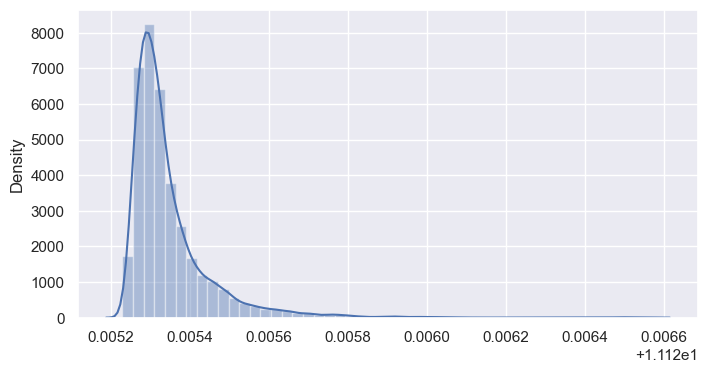

In [100]:
sns.distplot(np.array(output_dict['aleatoric_var'][:,index_best_model].mean(dim=1)))

In [79]:
print(rmse, mae)

11.129820020785179 3.5838455456637273


In [155]:
# nomal_mean = 2*torch.log(final_preds) - 0.5*torch.log(final_var + torch.square(final_preds))
# normal_var = -2*torch.log(final_preds) + torch.log(final_var + torch.square(final_preds))
# normal_025 = nomal_mean - 2*torch.sqrt(normal_var)
# normal_975 = nomal_mean + 2*torch.sqrt(normal_var)

normal_var = torch.log(final_var/torch.square(final_preds) + 1)
nomal_mean = torch.log(final_preds) - 0.5*normal_var
normal_025 = nomal_mean - 2*torch.sqrt(normal_var)
normal_975 = nomal_mean + 2*torch.sqrt(normal_var)

# normal_var = torch.square(torch.log(torch.sqrt(final_var)/final_preds + 1))
# nomal_mean = torch.log(torch.square(final_preds)/final_var + torch.square(final_preds))
# normal_025 = nomal_mean - 2*torch.sqrt(normal_var)
# normal_975 = nomal_mean + 2*torch.sqrt(normal_var)

normal_var = torch.log(final_var/torch.square(final_preds) + 1)
nomal_mean = torch.log( torch.square(final_preds) / torch.sqrt(final_var + torch.square(final_preds)) )
normal_025 = nomal_mean - 2*torch.sqrt(normal_var)
normal_975 = nomal_mean + 2*torch.sqrt(normal_var)

In [156]:
normal_975

tensor([2.2293, 2.2285, 2.2277,  ..., 2.2470, 2.2489, 2.2493],
       dtype=torch.float64)

In [153]:
np.mean(np.where(output_dict['y_trues'] < np.array(torch.exp(normal_975)),1,0))

np.float64(0.9229807291499663)

In [154]:
np.mean(np.where(output_dict['y_trues'] > np.array(torch.exp(normal_025)),1,0))

np.float64(0.7152659762080354)

In [144]:
output_dict['y_trues']

array([1.63163003e-02, 1.00010005e-03, 4.08722013e-02, ...,
       1.52988994e+00, 9.35145140e-01, 9.83765185e-01])

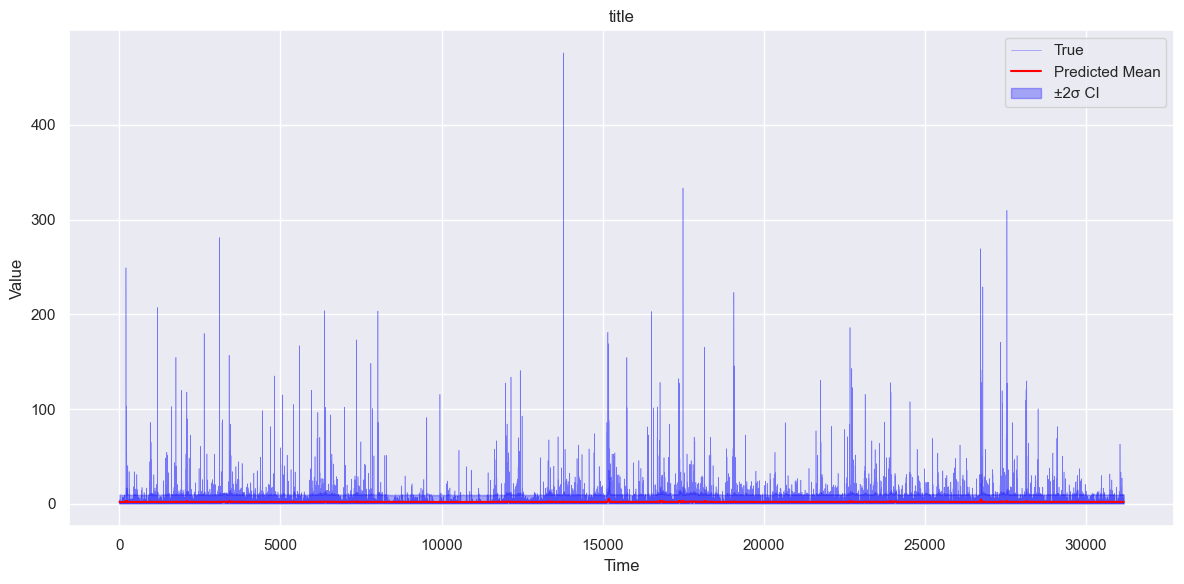

In [157]:
time = np.arange(len(final_preds))
plt.figure(figsize=(12, 6))
plt.plot(time, output_dict['y_trues'], label='True', color='blue', linewidth=0.4, alpha=0.5)
plt.plot(time, final_preds, label='Predicted Mean', color='red')
plt.fill_between(time, torch.exp(normal_025), torch.exp(normal_975), color='blue', alpha=0.3, label='±2σ CI')
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('title')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
plt.figure(figsize=(10, 3.5))
plt.fill_between(range(len(predictions.mean(1))), torch.maximum(torch.tensor(0),predictions.mean(1)-1.96*torch.sqrt(IW.mean(0) - torch.square(predictions.mean(1)))), predictions.mean(1)+1.96*torch.sqrt(IW.mean(0) - torch.square(predictions.mean(1))),
                    color="#4C72B0", alpha=0.15, label="95 % band")
plt.plot(test_df['total_volume'].iloc[h:].reset_index()['total_volume'], label="true", color="#4C72B0", alpha=.8, linewidth=1.0)
plt.plot(predictions.mean(1), label="pred", color="#BD561A", alpha=.9, linewidth=1.2)
plt.title("Test – total volume (±1.96 σ)")
plt.xlabel("sample");
plt.ylabel("volume")
plt.legend();
plt.tight_layout();
plt.show()